## Data Loading and Selection

## A. Baseline Model:
   > ### Word Exploration
   > ### Naive Bayes
   > ### PassiveAgressive
   > ### Section Summary

## B. Hyper-parameter Tuning
### Automatic - Gridsearch
   > #### Naive Bayes and PassiveAgressive Classifiers
   
> ### Section Summary

### Manual - using 'text' feature
   > #### Extract Dropped-words
   > #### Calculate number of Dropped-words

> ### Section Summary

## C. Run Tuned Models & Evaluate
> ### Naive Bayes - 'text' Model
    > ### Analysis and Evaluation
> ### PassiveAgressive - 'text' Model
    > ### Analysis and Evaluation

## D. Two feature Model
> ### Vectorize 'title' and add title_length
> ### Run and Evaluate Model
> ### Section Summary

## E. Model Comparisons: NB, PA and Logistic Regression

## F. Stress Tests
> ### A) Naive Bayes - text
> ### B) Naive Bayes - title
> ### C) PassivAgressive - 'text'
> ### Can we further generalize the model?

## G. Conclusion
## H. Future Recommendations

## References

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html 
# from IPython.display import display, HTML

%matplotlib inline

import nltk
from nltk.corpus import stopwords
#from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn import model_selection


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [3]:
from sklearn import metrics
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
from IPython.display import display_html
from IPython.display import HTML

In [5]:
def count_droppedwords(hyper_paramsdf):
    
    """ Function to calculate the number of stop-words (Droppedwords).
    input is the droppedwords dataframe."""
    
    list1=[]
    # Loop through rows of dataframe by index
    for i in range(0, hyper_paramsdf.shape[0]):
        
       # get ['Droppedwords'] length by row
        rowSeries = len(hyper_paramsdf.iloc[i]['Droppedwords'])
        
        list1.append(rowSeries) # attach to list
        
    return list1
       # print row contents
       

In [6]:
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
        by Anton Golubev
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

## Data Loading and Selection

In [7]:
allnews = pd.read_csv('allnews_extra_title_clean.csv')

In [8]:
allnews.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
allnews.head(3)

date                                              title  \
0  2017-12-31   Donald Trump Sends Out Embarrassing New Year’...   
1  2017-12-31   Drunk Bragging Trump Staffer Started Russian ...   
2  2017-12-30   Sheriff David Clarke Becomes An Internet Joke...   

                                                text subject  title_length  \
0  Donald Trump just couldn t wish all Americans ...    News            79   
1  House Intelligence Committee Chairman Devin Nu...    News            69   
2  On Friday, it was revealed that former Milwauk...    News            90   

   text_length  year  month weekday name  label  
0         2893  2017     12       Sunday      0  
1         1898  2017     12       Sunday      0  
2         3597  2017     12     Saturday      0

In [81]:
allnews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38137 entries, 0 to 38136
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    38137 non-null  int64 
 1   Unnamed: 0.1  38137 non-null  int64 
 2   date          38137 non-null  object
 3   title         38137 non-null  object
 4   text          38137 non-null  object
 5   subject       38137 non-null  object
 6   title_length  38137 non-null  int64 
 7   text_length   38137 non-null  int64 
 8   year          38137 non-null  int64 
 9   month         38137 non-null  int64 
 10  weekday name  38137 non-null  object
 11  labels        38137 non-null  int64 
 12  label         38137 non-null  int64 
dtypes: int64(8), object(5)
memory usage: 3.8+ MB


In [8]:
def run_default_pipe(X,y, estimator):
    
    """ Function to run the ML models using the default parameters.
    1. The data is split into train/test.
    2. A pipeline is et to vectorize and model the input text data.
    3. Test data is used for prediction and the outcome evaluated."""
    
    global feature_names, nb_log_prob, coeff
    
    # Split/Train_Test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                                        test_size=0.3, random_state=333)

    #Pipeline:
    pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('classifier',estimator) # switch classifiers here to test different ones
            ])

    # fit model
    pipeline.fit(X_train,y_train)
    
    # predict train/test
    predict_train = pipeline.predict(X_train)
    predict_test = pipeline.predict(X_test)
    
    model_eval={}
    # Calculate score for train/test
    accuracy_score_train = round(metrics.accuracy_score(y_train,predict_train), 4)
    accuracy_score_test = round(metrics.accuracy_score(y_test,predict_test), 4)
    f1_score_train = round(metrics.f1_score(y_train,predict_train), 4)
    f1_score_test = round(metrics.f1_score(y_test, predict_test),4)
    
    model_eval['accuracy_train']=accuracy_score_train*100
    model_eval['accuracy_test']= accuracy_score_test*100
    model_eval['f1_train']=f1_score_train*100
    model_eval['f1_test']= f1_score_test*100
    
       
    return model_eval#class_rep_train, class_rep_test
   

## A. Baseline Models:

### Word Exploration

To have an idea about which words are associated with Fake and Real news, a default pipeline was run using tfidfVector and Naive Bayes classifier. Looking at the top 10 words with a high probability of being fake, and those with a high probability of being real, the word 'trump' features prominently. The other 9 words are words that occur very frequently in the English language (stop words).<br>
After eliminating the stopwords, clinton, hilary, obama and donald emerged in the high probability fake category. It is worth noting that the dataset used here includes articles in the months prior, during and after the 2016 election.

In [48]:
# Split/Train_Test:
X= allnews['text']
y= allnews['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                    test_size=0.3, random_state=333)

pipeline_nb_default = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('classifier',MultinomialNB()) # switch classifiers here to test different ones
            ])

pipeline_nb_default.fit(X_train,y_train)
    
feature_names = pipeline_nb_default.steps[0][1].get_feature_names()
nb_log_prob = pipeline_nb_default.steps[1][1].feature_log_prob_
coeff = pipeline_nb_default.steps[1][1].coef_

In [38]:
nb_default_feature_log_prob_raw = pd.DataFrame(nb_log_prob, columns=feature_names).transpose()

# High probability words appearing in False news:
nb_default_feature_log_prob_raw_false = nb_default_feature_log_prob_raw.sort_values(by=0, ascending=False)[:10]

In [39]:
# High probability words appearing in Real news:
nb_default_feature_log_prob_raw_real = nb_default_feature_log_prob.sort_values(by=1, ascending=False)[:10]

**Table 1**<br>
Table to the left 'Fake -0' shows the table sorted by '0'. The top word 'the' has the highest likehood of showing up in fake news.<br>
Table to the right 'Real -1' is sorted by '1' (the news articles labeled as real). This also has the most likely word as 'the'. This makes a lot of sense since it's one of the most common words in the English language (termed stop-words).<br>
It is no surprise then, that the top 5 words in the corpus are stop-words: to, of, and and in.

In [46]:
display_side_by_side([nb_default_feature_log_prob_raw_false, nb_default_feature_log_prob_raw_real],
                     ['High Probability:  Fake - 0', 'Real - 1'])

Remove some of the less informative words:

In [62]:
nb_default_feature_log_prob_sw = pd.DataFrame(nb_log_prob, columns=feature_names).transpose()

# High probability words appearing in False news:
nb_default_feature_log_prob_sw_fake = nb_default_feature_log_prob_sw.sort_values(by=0, ascending=False)[:15]

In [63]:
# High probability words appearing in Real news:
nb_default_feature_log_prob_sw_real = nb_default_feature_log_prob_sw.sort_values(by=1, ascending=False)[:15]

**Table 2**<br>
Here the stop-words have been removed, and we get a better idea of the 15 most common words in fake news (to the left), and real news (the right table column '1').<br>
It is interesting to note that 'twitter' features in the high likelihood of being false category, while 'reuters' is in the high likelihood real news category.<br>

In [65]:
display_side_by_side([nb_default_feature_log_prob_sw_fake, nb_default_feature_log_prob_sw_real],
                     ['High Probability:  Fake - 0', 'Real - 1'])

**Table 3a**

Table 3a shows the same information as Table 2 Real-1 column 0. The coefficient attribute of the Naive Bayes model is the same as the 'success' case in the log_probability table.

In [68]:
# coef_
nb_default_feature_log_prob_sw = pd.DataFrame(coeff, columns=feature_names).transpose()
most_import_feature_coef = nb_default_feature_log_prob_sw.sort_values(by=0,ascending=False)[:10]
most_import_feature_coef

0
said       -5.604735
trump      -5.954347
reuters    -6.360286
president  -6.512761
state      -6.677177
house      -6.688530
government -6.766397
washington -6.800625
republican -6.808282
united     -6.874244

**Table 3b**

Table 3b shows the words with the *least* likelihood of being real, for the success case in our problem.

In [71]:
nb_default_feature_log_prob_sw = pd.DataFrame(coeff, columns=feature_names).transpose()
most_import_feature_coef = nb_default_feature_log_prob_sw.sort_values(by=0,ascending=False)[:10]
most_import_feature_coef

0
emuwhatyougonedo -12.363095
peckham          -12.363095
pecking          -12.363095
peckumn          -12.363095
emulsified       -12.363095
emullensemperfi  -12.363095
peculiarity      -12.363095
peculiarly       -12.363095
emulation        -12.363095
kevinmhardy      -12.363095

In [78]:
# print idf values 
nb_default_feature_idf = pd.DataFrame(nb_default_feature_idf, 
                                             index=feature_names,columns=["idf_weights"]) 
 
# sort ascending 
_ascend = nb_default_feature_idf.sort_values(by=['idf_weights']).head(15)
_desc = nb_default_feature_idf.sort_values(by=['idf_weights'], ascending=False).head(15)

**Table 4**<br>
The inverse document frequency is an indicator of how often a word shows up in a document. 'said, 'reuters', 'president' and 'trump' are the most common in the news articles in our dataset, which indicates a possible skew in the data towards US and US related political news.

In [79]:
display_side_by_side([_ascend, _desc], ['Idfs Ascending', 'idfs Decending'])

### Naive Bayes

In [7]:
# Run Naive Bayes model using default settings:
# Only 'title' is utilized
default_nb_title = run_default_pipe(allnews['title'], allnews['label'],MultinomialNB())

In [8]:
default_nb_title 

{'accuracy_train': 95.8,
 'accuracy_test': 94.28,
 'f1_train': 96.17,
 'f1_test': 94.71000000000001}

In [9]:
# Run Naive Bayes model using default settings, utilizing only 'text'
default_nb_text = run_default_pipe(allnews['text'], allnews['label'],MultinomialNB())

In [10]:
default_nb_text

{'accuracy_train': 94.42,
 'accuracy_test': 93.56,
 'f1_train': 95.02000000000001,
 'f1_test': 94.19999999999999}

### PassiveAgressive

In [11]:
# Run PassiveAggressive Classifier using defaults
default_pa_title = run_default_pipe(allnews['title'], allnews['label'],PassiveAggressiveClassifier())

In [12]:
default_pa_title

{'accuracy_train': 100.0,
 'accuracy_test': 94.0,
 'f1_train': 100.0,
 'f1_test': 94.47}

In [13]:
default_pa_text = run_default_pipe(allnews['text'], allnews['label'],PassiveAggressiveClassifier())

In [14]:
default_pa_text

{'accuracy_train': 100.0,
 'accuracy_test': 99.15,
 'f1_train': 100.0,
 'f1_test': 99.22}

In [15]:
# Baseline model evaluation:
mydicts = [default_nb_title, default_nb_text, default_pa_title, default_pa_text]
defaults = pd.DataFrame.from_records(mydicts,index= ['default_nb_title', 'default_nb_text',
                                                       'default_pa_title', 'default_pa_text'])
defaults

accuracy_train  accuracy_test  f1_train  f1_test
default_nb_title           95.80          94.28     96.17    94.71
default_nb_text            94.42          93.56     95.02    94.20
default_pa_title          100.00          94.00    100.00    94.47
default_pa_text           100.00          99.15    100.00    99.22

#### Section Summary:

The first step was to explore the words in the corpus associated with fake and real news. An interesting finding was the presence of the words 'trump' and 'president' in both fake *and* real news while other names prominent in the 2016 election such as 'hilary', 'obama' and 'donald' also featured in the top 15 high probability fake category.<br>
Other words that ranked in the top 15 real news category included 'reuters', 'washington', 'state', and 'government'. These words would be good to eliminate in the future in order to force the model to learn coefficients on less extreme/more diverse words. These and other words (as seen in tables 2 and/or 3a) give an indication that the news dataset here is skewed towards US politics.<br>

Tables 3a and b show the log_probability values for *both* the Fake(0) and Real(1) classes. This is one of the attributes output by the Naive Bayes classifier. A high log_probability of a word being in fake news corresponds to a small log probability value, in that category. Likewise, a high log_probability of a word being in real news correponds to a small, negative log probability value in the '1' class.<br>
Another output of this modeling technique in scikit learn is coef_: this is similar to the log_probability, but *only* for the 'success' class, 1. In our case this is 'Real' category.<br>

In order to have a baseline model to which any future improvements will be compared, I ran a total of four models:<br>
+ Naive Bayes classifier on the title column<br>
+ Naive Bayes classifier on the text column<br>
+ Passive Agressive classifer on the title column, and <br>
+ Passive Agressive classifier on the text column.<br>
These 4 represent the 'simplest' models since only one column is utilized at a time.<br>

PassiveAgressive Classifer gives the best accuracy and f1 scores for the model using 'text' (99.1%). The default parameters, in this case, seem to be sufficient such that no further tuning is required. The initial model will be run using this feature.
Hyper-parameter tuning will be conducted for Naive Bayes using titles, and text in an attempt to improve the model.

## B. Hyper-parameter Tuning
### Automatic - Gridsearch

In [9]:
def model_tune_pipe(X, y):
    
    """ Function to run Pipeline for TfidfVectorize and model using Naive Bayes with 
    tuned hyper-parameters.
    Input data format: X(series) and y(series)    
    """
    
           
    # Split/Train_Test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, 
                                                        test_size=0.3, random_state=333)
    
     
    #Pipeline:
    pipe = Pipeline([
                ('tfidf', TfidfVectorizer()),
                #('classifier', MultinomialNB()),
                ('classifier', PassiveAggressiveClassifier(max_iter=5000, random_state=34))
            ])

    params_grid = {'tfidf__min_df': [1,2,3],
                   'tfidf__max_df': np.arange(0.4, 1, 0.2),
                   'tfidf__analyzer': ['word', 'char'],
                   'tfidf__strip_accents': ['ascii', 'unicode', None],
                   'tfidf__ngram_range': [(1,1),(1,2),(1,3)],
                   #'classifier__alpha': np.arange(0.1,1.0,0.2),
                   'classifier__C': np.arange(0.01, 1, 0.1),
                       }
                   
    
    clf = GridSearchCV(pipe, params_grid, cv=5, scoring='f1').fit(X_train, y_train)
    
    # predict
    print('Best_score: ', clf.best_score_)
    print('Best_params: ', clf.best_params_)
    
    return clf.best_score_, clf.best_params_

#### Naive Bayes - title:

Gridsearch is a method to find the best hyper-parameters for the vectorizer and the classifier, at the same time. A dictionary (params_grid) had the values saved in lists. Five parameters were varied as such, while the others were defaults.<br>
The Naive Bayes alpha values tested were 0.1 to 1.0, at 0.1 intervals. For the Passive Agressive classifier, only the regularization parameter, C  was changed while the others were kept constant.

In [119]:
#gridsearch Naive Bayes - title column:
nb_gs_title = model_tune_pipe(allnews['title'], allnews['label'])

Best_score:  0.9594680651807455
Best_params:  {'classifier__alpha': 0.1, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.4, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode'}


In [121]:
nb_gs_title # gridsearch - naive bayes using title

(0.9594680651807455,
 {'classifier__alpha': 0.1,
  'tfidf__analyzer': 'char',
  'tfidf__max_df': 0.4,
  'tfidf__min_df': 1,
  'tfidf__ngram_range': (1, 3),
  'tfidf__strip_accents': 'unicode'})

#### PassiveAgressive Classifier - title:

In [123]:
#gridsearch PassivAgressive Classification - title feature:
pa_gs_title = model_tune_pipe(allnews['title'], allnews['label'])

Best_score:  0.971268027720547
Best_params:  {'classifier__C': 0.11, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.8000000000000002, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode'}


In [124]:
pa_gs_title

(0.971268027720547,
 {'classifier__C': 0.11,
  'tfidf__analyzer': 'char',
  'tfidf__max_df': 0.8000000000000002,
  'tfidf__min_df': 3,
  'tfidf__ngram_range': (1, 3),
  'tfidf__strip_accents': 'unicode'})

In [10]:
# Using f1 as scoring method, yields similar results
pa_gs_title_f1 = model_tune_pipe(allnews['title'], allnews['label'])
# max_iter=5000, random_state=34, scoring='f1'

Best_score:  0.9738865521870286
Best_params:  {'classifier__C': 0.11, 'tfidf__analyzer': 'char', 'tfidf__max_df': 0.8000000000000002, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 3), 'tfidf__strip_accents': 'unicode'}


### Manual tuning:

This method of tuning was chosen for 2 reasons:<br>
_ It allows for developing an intuition about the effect of the various parameters, and<br>
_ Less computational time, since the process is divided into 2 pieces.<br>
_ Allows analysis in between the 2 tuning processes (e.g. output stop-words, idf values).<br>

In the first iteration of the hyper-parameter tuning, only min_df, max_df and stop_words were experimented with. Range of values tested:<br>
min_df: *1*,2,**3**<br>
max_df: *0.4*, 0.6, **0.8**, 1.0<br>
stop-words: *None*, 'english'<br>

The best values from RUN1 are then fixed in RUN2 while another three parameters are tested. They are:<br>
analyzers: 'word', **'char'**<br>
strip_accents: 'unicode', **None**<br>
ngram_ranges: (1,1), (1,2), **(1,3)**<br>

As far as the classifier parameters are concerned, alpha for Naive Bayes and C in PA were taken from the GridSearch results.

**: Naive Bayes or both**(if no italics on same parameter).<br>
*: Passive Agressive parameters*.

In [11]:
# input data for hyper-parameter tuning:
# to text for 'title' feature, replace in All2['text']

X_train, X_test, y_train, y_test = train_test_split(allnews['text'], allnews['label'], shuffle=True, 
                                                                    test_size=0.3, random_state=333)

In [12]:
# Hyper-parameters to be tested:
# This cell was run TWICE, to test two sets of hyper_parameters for TfIDFVectorizer.
# RUN1: max_df, min_df and stop_words.
# RUN2: Best params from RUN1 + analyzers, strip_accents, ngram_ranges

maxdf_vals = [0.4, 0.6, 0.8, 1.0]
mindf_vals = [1,2,3]
stop_words = [None, 'english']

#analyzers = ['word', 'char']
#strip_accents = ['unicode', None]
#ngram_ranges = [(1,1), (1,2),(1,3)]

hyper_params_table = []  # initialize hyper_parameter table
#hyper_params_nb_table = [{'alpha':0.1}] # model hyper_parameter table
hyper_params_pa_table = [{'C':0.001}, {'C':0.01}, {'C':0.1}]

#for max_df in maxdf_vals:
    #for min_df in mindf_vals:
        #for stopword in stop_words:
                
            #hyper_params = {}        # initialize hyper_parameter dictionary
            #hyper_params['min_df'] = min_df
            #hyper_params['max_df'] = max_df
            #hyper_params['stop_words'] = stopword
            
            #hyper_params_table.append(hyper_params)
            
for analyzer in analyzers:
    for strip_accent in strip_accents:
        for ngram_range in ngram_ranges:
            hyper_params = {'max_df': 0.8, 'min_df': 3, 'stop_words': None}
            hyper_params['analyzer'] = analyzer
            hyper_params['strip_accents'] = strip_accent
            hyper_params['ngram_range'] = ngram_range
            
            hyper_params_table.append(hyper_params)
            
hyper_params_table# output table with all hyper-parameters for testing the model

[{'max_df': 0.8,
  'min_df': 3,
  'stop_words': None,
  'analyzer': 'word',
  'strip_accents': 'unicode',
  'ngram_range': (1, 3)},
 {'max_df': 0.8,
  'min_df': 3,
  'stop_words': None,
  'analyzer': 'word',
  'strip_accents': None,
  'ngram_range': (1, 3)},
 {'max_df': 0.8,
  'min_df': 3,
  'stop_words': None,
  'analyzer': 'char',
  'strip_accents': 'unicode',
  'ngram_range': (1, 3)},
 {'max_df': 0.8,
  'min_df': 3,
  'stop_words': None,
  'analyzer': 'char',
  'strip_accents': None,
  'ngram_range': (1, 3)}]

In [13]:
# Run pipeline using all hyper-parameters from the hyper_params_table list of dictionaries.
# Fit the model, predict and calculate the accuracy score for train and test data.
# Hyper-parameter table for RUN1 = hyper_param_table_tfidf_1
# Hyper_parameter table for RUN2{RUN1+analyzers+strip_accents+ngram_ranges} = hyper_param_table_tfidf_2

hyper_params_table_combined = []

for j, hyper_params_pa in enumerate(hyper_params_pa_table):
    for i, hyper_params in enumerate(hyper_params_table):
        
        hyper_params_combined = {}
        hyper_params_combined.update(hyper_params_pa)
        hyper_params_combined.update(hyper_params)
        
        hyper_params_table_combined.append(hyper_params_combined)
        
        
        pipeline_pa = Pipeline([
            ('tfidf', TfidfVectorizer(**hyper_params)),
            ('classifier', PassiveAggressiveClassifier(**hyper_params_pa))
        ])

        # fit model
        pipeline_pa.fit(X_train,y_train)

        # predict train/test
        predict_train = pipeline_pa.predict(X_train)
        predict_test = pipeline_pa.predict(X_test)
        
        # Calculate score for train/test
        hyper_params_table_combined[-1]['accuracy_train'] = metrics.accuracy_score(y_train,predict_train)
        hyper_params_table_combined[-1]['accuracy_test'] = metrics.accuracy_score(y_test,predict_test)
        hyper_params_table_combined[-1]['f1_train'] = metrics.f1_score(y_train,predict_train)
        hyper_params_table_combined[-1]['f1_test'] = metrics.f1_score(y_test,predict_test)

        #Words eliminated:
        hyper_params_table_combined[-1]['Droppedwords'] = pipeline_pa.steps[0][1].stop_words_

hyper_params_table_combined

#store in dataframe
hyper_params_table_combined_df = pd.DataFrame(hyper_params_table_combined)

In [14]:
pa_hyper_params_text_test2 =  hyper_params_table_combined_df
pa_hyper_params_text_test2.sort_values(by='f1_test', ascending=False)

C  max_df  min_df stop_words analyzer strip_accents ngram_range  \
11  0.100     0.8       3       None     char          None      (1, 3)   
10  0.100     0.8       3       None     char       unicode      (1, 3)   
7   0.010     0.8       3       None     char          None      (1, 3)   
6   0.010     0.8       3       None     char       unicode      (1, 3)   
2   0.001     0.8       3       None     char       unicode      (1, 3)   
3   0.001     0.8       3       None     char          None      (1, 3)   
9   0.100     0.8       3       None     word          None      (1, 3)   
8   0.100     0.8       3       None     word       unicode      (1, 3)   
5   0.010     0.8       3       None     word          None      (1, 3)   
4   0.010     0.8       3       None     word       unicode      (1, 3)   
0   0.001     0.8       3       None     word       unicode      (1, 3)   
1   0.001     0.8       3       None     word          None      (1, 3)   

    accuracy_train  accuracy_test  f1_train   f1_test  \
11        0.999925       0.999388  0.999932  0.999435   
10        0.999888       0.999301  0.999897  0.999354   
7         0.999101       0.998514  0.999179  0.998628   
6         0.999101       0.998427  0.999179  0.998547   
2         0.995842       0.995018  0.996209  0.995407   
3         0.995767       0.995018  0.996141  0.995407   
9         0.999738       0.993970  0.999761  0.994441   
8         0.999738       0.993882  0.999761  0.994360   
5         0.996291       0.990911  0.996616  0.991625   
4         0.996179       0.990474  0.996513  0.991226   
0         0.982431       0.977277  0.984051  0.979147   
1         0.982431       0.977277  0.984051  0.979147   

                                         Droppedwords  
11  {oqv, +po, fmk, lu3, up—, *ex, ;g<, =ja, cvo, ...  
10  {oqv, +po, fmk, lu3, up—, *ex, ;g<, =ja, cvo, ...  
7   {oqv, +po, fmk, lu3, up—, *ex, ;g<, =ja, cvo, ...  
6   {oqv, +po, fmk, lu3, up—, *ex, ;g<, =ja, cvo, ...  
2   {oqv, +po, fmk, lu3, up—, *ex, ;g<, =ja, cvo, ...  
3   {oqv, +po, fmk, lu3, up—, *ex, ;g<, =ja, cvo, ...  
9   {for trump daughter, antagonize them the, both...  
8   {for trump daughter, antagonize them the, both...  
5   {for trump daughter, antagonize them the, both...  
4   {for trump daughter, antagonize them the, both...  
0   {for trump daughter, antagonize them the, both...  
1   {for trump daughter, antagonize them the, both...

#### PassiveAggressive Classifier Manual Tuning:
#### PA-RUN 2

In [167]:
pa_hyper_params_text_run2 =  hyper_params_table_combined_df
pa_hyper_params_text_run2.sort_values(by='f1_test', ascending=False)

C  max_df  min_df stop_words analyzer strip_accents ngram_range  \
11  0.1     0.8       3       None     char          None      (1, 3)   
8   0.1     0.8       3       None     char       unicode      (1, 3)   
7   0.1     0.8       3       None     char       unicode      (1, 2)   
10  0.1     0.8       3       None     char          None      (1, 2)   
1   0.1     0.8       3       None     word       unicode      (1, 2)   
4   0.1     0.8       3       None     word          None      (1, 2)   
2   0.1     0.8       3       None     word       unicode      (1, 3)   
5   0.1     0.8       3       None     word          None      (1, 3)   
3   0.1     0.8       3       None     word          None      (1, 1)   
0   0.1     0.8       3       None     word       unicode      (1, 1)   
9   0.1     0.8       3       None     char          None      (1, 1)   
6   0.1     0.8       3       None     char       unicode      (1, 1)   

    accuracy_train  accuracy_test  f1_train   f1_test  \
11        0.999925       0.999301  0.999932  0.999354   
8         0.999888       0.999301  0.999897  0.999354   
7         0.999513       0.998077  0.999556  0.998225   
10        0.999401       0.998077  0.999453  0.998225   
1         0.999700       0.994581  0.999726  0.995004   
4         0.999700       0.994407  0.999726  0.994842   
2         0.999738       0.993882  0.999761  0.994359   
5         0.999738       0.993795  0.999761  0.994279   
3         0.999138       0.993358  0.999214  0.993874   
0         0.998989       0.993270  0.999077  0.993795   
9         0.953737       0.950096  0.957969  0.954022   
6         0.952238       0.946513  0.956346  0.950461   

                                         Droppedwords  
11  {ixd, oh/, gf4, k3w, /95, )ev, [gs, fd-, y=k, ...  
8   {ixd, oh/, gf4, k3w, /95, )ev, [gs, fd-, y=k, ...  
7   {em, fe, b+, •, ~3, %u, /(, l\, i$, ge, 1\, ts...  
10  {em, fe, b+, •, ~3, %u, /(, l\, i$, ge, 1\, ts...  
1   {load which, creating vicious, unassailable st...  
4   {load which, creating vicious, unassailable st...  
2   {did not mix, pc era, things day to, will accu...  
5   {did not mix, pc era, things day to, will accu...  
3   {tostring, schumerfeatured, safekeeping, baled...  
0   {tostring, schumerfeatured, safekeeping, baled...  
9   {ö, ´, •, t, v, r, ☑, ê, ,, ️, ō, a, ô, o, ­, ...  
6   {•, t, v, r, ☑, ,, ️, a, o, ­, k, j, u, -, i, ...

In [168]:
# feature names
pa_hyper_params_text_run2_feature_names = pipeline_pa.steps[0][1].get_feature_names()

In [169]:
#idf weights vector
pa_hyper_params_text_run2_idf = pipeline_pa.steps[0][1].idf_

In [170]:
# print idf values 
pa_hyper_params_text_run2_idf = pd.DataFrame(pa_hyper_params_text_run2_idf, 
                                             index=pa_hyper_params_text_run2_feature_names,columns=["idf_weights"]) 
 
# sort ascending 
pa_text_run2_ascend = pa_hyper_params_text_run2_idf.sort_values(by=['idf_weights']).head(10)
pa_text_run2_desc = pa_hyper_params_text_run2_idf.sort_values(by=['idf_weights'], ascending=False).head(10)

In [171]:
display_side_by_side([ pa_text_run2_ascend, pa_text_run2_desc], ['Idfs Ascending', 'idfs Decending'])

#### PA-RUN 1

In the first run of the PA model hyper-tuning, the highest f1 was achieved with min_df of 3, max_df of 0.8 and stop-words of None. However, in all 24 instances(combination of parameters), f1 values were 98% for the test set, and over 99% for the training set. This could indicate an overfitting of the model.<br>

It is interesting to note that the top performing 7models had stop-words=None, and yet, many of the freuqntly used English stop-words, were successfully eliminated even with max_df set to 0.6 or lower . Even 0.8 was successful in removing 9 freuquently used English stop-words (such as is seen in row 12 below).max_df is the threshold for words that appear **frequently**. A threshold of 0.8 eliminates words that are found in 80% of the documents.<br>

Min_df highlights **rare** words. A min_df of 1 means the occurance of words in one or less documents in the corpus.

In [160]:
pa_hyper_params_text_run1 =  hyper_params_table_combined_df
pa_hyper_params_text_run1.sort_values(by='f1_test', ascending=False)

C  min_df  max_df stop_words  accuracy_train  accuracy_test  f1_train  \
16  0.1       3     0.8       None        0.999026       0.993533  0.999111   
14  0.1       2     0.8       None        0.998989       0.993358  0.999077   
12  0.1       1     0.8       None        0.999063       0.993270  0.999146   
8   0.1       2     0.6       None        0.999251       0.993008  0.999317   
6   0.1       1     0.6       None        0.999251       0.992746  0.999317   
20  0.1       2     1.0       None        0.999026       0.992659  0.999111   
10  0.1       3     0.6       None        0.999251       0.992659  0.999317   
11  0.1       3     0.6    english        0.999101       0.992484  0.999180   
9   0.1       2     0.6    english        0.999063       0.992396  0.999146   
7   0.1       1     0.6    english        0.999176       0.992309  0.999248   
23  0.1       3     1.0    english        0.998989       0.992222  0.999077   
18  0.1       1     1.0       None        0.999063       0.992134  0.999146   
22  0.1       3     1.0       None        0.999063       0.992134  0.999146   
17  0.1       3     0.8    english        0.998989       0.992047  0.999077   
13  0.1       1     0.8    english        0.999026       0.991959  0.999111   
15  0.1       2     0.8    english        0.998989       0.991872  0.999077   
19  0.1       1     1.0    english        0.999026       0.991872  0.999111   
21  0.1       2     1.0    english        0.999026       0.991872  0.999111   
0   0.1       1     0.4       None        0.998914       0.986541  0.999009   
4   0.1       3     0.4       None        0.998914       0.986366  0.999009   
2   0.1       2     0.4       None        0.998914       0.986366  0.999009   
5   0.1       3     0.4    english        0.998502       0.984618  0.998634   
1   0.1       1     0.4    english        0.998577       0.984531  0.998702   
3   0.1       2     0.4    english        0.998614       0.984443  0.998736   

     f1_test                                       Droppedwords  
16  0.994037  {tostring, schumerfeatured, safekeeping, baled...  
14  0.993873  {schumerfeatured, safekeeping, baled, czntdlgo...  
12  0.993792          {the, that, on, and, to, in, is, for, of}  
8   0.993553  {schumerfeatured, safekeeping, baled, czntdlgo...  
6   0.993312  {but, on, who, his, for, has, this, and, was, ...  
20  0.993233  {schumerfeatured, safekeeping, baled, czntdlgo...  
10  0.993231  {tostring, schumerfeatured, safekeeping, baled...  
11  0.993072  {tostring, schumerfeatured, safekeeping, baled...  
9   0.992993  {schumerfeatured, safekeeping, baled, czntdlgo...  
7   0.992911                                             {said}  
23  0.992827  {tostring, schumerfeatured, safekeeping, baled...  
18  0.992754                                                 {}  
22  0.992751  {tostring, schumerfeatured, safekeeping, baled...  
17  0.992669  {tostring, schumerfeatured, safekeeping, baled...  
13  0.992589                                                 {}  
15  0.992509  {schumerfeatured, safekeeping, baled, czntdlgo...  
19  0.992509                                                 {}  
21  0.992507  {schumerfeatured, safekeeping, baled, czntdlgo...  
0   0.987583  {president, people, trump, but, on, who, his, ...  
4   0.987429  {tostring, schumerfeatured, safekeeping, baled...  
2   0.987427  {schumerfeatured, safekeeping, baled, czntdlgo...  
5   0.985818  {tostring, schumerfeatured, safekeeping, baled...  
1   0.985741  {president, people, trump, reuters, donald, said}  
3   0.985652  {schumerfeatured, safekeeping, baled, czntdlgo...

In [161]:
# feature names
pa_hyper_params_text_run1_feature_names = pipeline_pa.steps[0][1].get_feature_names()

In [162]:
#idf weights vector
pa_hyper_params_text_run1_idf = pipeline_pa.steps[0][1].idf_

In [163]:
# print idf values 
pa_hyper_params_text_run1_idf= pd.DataFrame(pa_hyper_params_text_run1_idf, 
                                             index=pa_hyper_params_text_run1_feature_names,columns=["idf_weights"]) 
 
# sort ascending 
pa_text_run1_ascend = pa_hyper_params_text_run1_idf.sort_values(by=['idf_weights']).head(10)
pa_text_run1_desc = pa_hyper_params_text_run1_idf.sort_values(by=['idf_weights'], ascending=False).head(10)

In [164]:
display_side_by_side([ pa_text_run1_ascend, pa_text_run1_desc], ['Idfs Ascending', 'idfs Decending'])

The most abundant words in the news article 'text' are expected to have very low inverse document frequency(idf) numbers. Above, we can see that the top 10 contain 4 of what can be considered stop-words (said, new, told and just).<br>
The words president, trump and donald could be an indication that the corpus of articles we have are swayed towards US related news. We can also deduce that most of the articles we have come from *reuters*, a well known news agency.<br>

The more **rare** words seem more random, and perhaps are names of individuals or places(?)

In [54]:
nb_hyper_params_text_run2 = hyper_params_table_combined_df
nb_hyper_params_text_run2.sort_values(by='f1_test', ascending=False)

alpha  max_df  min_df stop_words analyzer strip_accents ngram_range  \
11    0.1     0.1       1       None     char          None      (1, 3)   
8     0.1     0.1       1       None     char       unicode      (1, 3)   
10    0.1     0.1       1       None     char          None      (1, 2)   
2     0.1     0.1       1       None     word       unicode      (1, 3)   
5     0.1     0.1       1       None     word          None      (1, 3)   
7     0.1     0.1       1       None     char       unicode      (1, 2)   
1     0.1     0.1       1       None     word       unicode      (1, 2)   
4     0.1     0.1       1       None     word          None      (1, 2)   
3     0.1     0.1       1       None     word          None      (1, 1)   
0     0.1     0.1       1       None     word       unicode      (1, 1)   
9     0.1     0.1       1       None     char          None      (1, 1)   
6     0.1     0.1       1       None     char       unicode      (1, 1)   

    accuracy_train  accuracy_test  f1_train   f1_test  
11        0.992508       0.989250  0.993195  0.990120  
8         0.992358       0.989163  0.993061  0.990042  
10        0.958269       0.960147  0.962286  0.963631  
2         0.996554       0.958224  0.996863  0.962327  
5         0.996554       0.958224  0.996863  0.962327  
7         0.956733       0.957263  0.960883  0.960995  
1         0.989324       0.953942  0.990305  0.958091  
4         0.989324       0.953942  0.990305  0.958091  
3         0.951601       0.931743  0.955787  0.936797  
0         0.951564       0.931655  0.955754  0.936721  
9         0.699007       0.692973  0.775690  0.770137  
6         0.691291       0.684146  0.770784  0.764099

In [66]:
nb_hyper_params_text_run2_stop_words = pipeline_nb.steps[0][1].stop_words_

In [67]:
len(nb_hyper_params_text_run2_stop_words)

2779

In [68]:
# feature names
nb_hyper_params_text_run2_feature_names = pipeline_nb.steps[0][1].get_feature_names()

In [69]:
#idf weights vector
nb_hyper_params_text_run2_idf = pipeline_nb.steps[0][1].idf_

In [79]:
# print idf values 
nb_hyper_params_text_run2_idf = pd.DataFrame(nb_hyper_params_text_run2_idf, 
                                             index=nb_hyper_params_text_run2_feature_names,columns=["idf_weights"]) 
 
# sort ascending 
nb_text_run2_ascend = nb_hyper_params_text_run2_idf.sort_values(by=['idf_weights']).head(10)
nb_text_run2_desc = nb_hyper_params_text_run2_idf.sort_values(by=['idf_weights'], ascending=False).head(10)

In [82]:
display_side_by_side([ nb_text_run2_ascend, nb_text_run2_desc], ['Idfs Ascending', 'idfs Decending'])

#### Manual Tuning - Naive Bayes:

RUN1: max_df=0.1, min_df=1, and alpha=0.1 resulted in the best f1 score of 94.5%. Using these parameters means no words were ignored(tagged as stop-words).<br>
Varying the parameters resulted in a different number of words to be regarded as 'stop-words'. These were calculated using the function count-droppedwords, and the result attached to the dataframe in a column named 'Word-len'. For example row12 in the dataframe nb_hyper_params_text_run1 max_df=0.8, min_df=1, and alpha=0.1, and stop-words=None identified 9 words as stop-words.

In [90]:
nb_hyper_params_text_run1 = hyper_params_table_combined_df
nb_hyper_params_text_run1.sort_values(by='f1_test', ascending=False)

alpha  min_df  max_df stop_words  accuracy_train  accuracy_test  f1_train  \
18    0.1       1     1.0       None        0.957370       0.940919  0.961197   
19    0.1       1     1.0    english        0.957033       0.940482  0.960897   
13    0.1       1     0.8    english        0.957033       0.940482  0.960897   
12    0.1       1     0.8       None        0.957558       0.940482  0.961346   
20    0.1       2     1.0       None        0.952463       0.940570  0.956566   
6     0.1       1     0.6       None        0.956996       0.940308  0.960830   
14    0.1       2     0.8       None        0.952650       0.940570  0.956703   
16    0.1       3     0.8       None        0.951152       0.940482  0.955315   
8     0.1       2     0.6       None        0.952388       0.940133  0.956462   
22    0.1       3     1.0       None        0.950815       0.939958  0.955030   
7     0.1       1     0.6    english        0.956246       0.939608  0.960156   
10    0.1       3     0.6       None        0.950328       0.939434  0.954545   
15    0.1       2     0.8    english        0.952238       0.939346  0.956328   
21    0.1       2     1.0    english        0.952238       0.939346  0.956328   
17    0.1       3     0.8    english        0.950253       0.939084  0.954492   
23    0.1       3     1.0    english        0.950253       0.939084  0.954492   
9     0.1       2     0.6    english        0.951527       0.938472  0.955670   
0     0.1       1     0.4       None        0.955797       0.938210  0.959708   
11    0.1       3     0.6    english        0.949466       0.938123  0.953736   
1     0.1       1     0.4    english        0.955048       0.937773  0.959033   
2     0.1       2     0.4       None        0.951077       0.937773  0.955216   
4     0.1       3     0.4       None        0.948979       0.937249  0.953270   
3     0.1       2     0.4    english        0.949916       0.937074  0.954148   
5     0.1       3     0.4    english        0.947893       0.936287  0.952250   

     f1_test                                       Droppedwords  
18  0.945528                                                 {}  
19  0.945120                                                 {}  
13  0.945120                                                 {}  
12  0.945067          {the, that, on, and, to, in, is, for, of}  
20  0.944921  {schumerfeatured, safekeeping, baled, czntdlgo...  
6   0.944888  {but, on, who, his, for, has, this, and, was, ...  
14  0.944877  {schumerfeatured, safekeeping, baled, czntdlgo...  
16  0.944755  {tostring, schumerfeatured, safekeeping, baled...  
8   0.944476  {schumerfeatured, safekeeping, baled, czntdlgo...  
22  0.944305  {tostring, schumerfeatured, safekeeping, baled...  
7   0.944279                                             {said}  
10  0.943755  {tostring, schumerfeatured, safekeeping, baled...  
15  0.943742  {schumerfeatured, safekeeping, baled, czntdlgo...  
21  0.943742  {schumerfeatured, safekeeping, baled, czntdlgo...  
17  0.943439  {tostring, schumerfeatured, safekeeping, baled...  
23  0.943439  {tostring, schumerfeatured, safekeeping, baled...  
9   0.942922  {schumerfeatured, safekeeping, baled, czntdlgo...  
0   0.942906  {president, people, trump, but, on, who, his, ...  
11  0.942560  {tostring, schumerfeatured, safekeeping, baled...  
1   0.942544  {president, people, trump, reuters, donald, said}  
2   0.942189  {schumerfeatured, safekeeping, baled, czntdlgo...  
4   0.941636  {tostring, schumerfeatured, safekeeping, baled...  
3   0.941558  {schumerfeatured, safekeeping, baled, czntdlgo...  
5   0.940785  {tostring, schumerfeatured, safekeeping, baled...

#### Inverse Document Frequencies:

In [91]:
# feature names
nb_hyper_params_text_run1_feature_names = pipeline_nb.steps[0][1].get_feature_names()

In [92]:
#idf weights vector
nb_hyper_params_text_run1_idf = pipeline_nb.steps[0][1].idf_

In [94]:
# print idf values 
nb_hyper_params_text_run1_idf = pd.DataFrame(nb_hyper_params_text_run1_idf, 
                                             index=nb_hyper_params_text_run1_feature_names,columns=["idf_weights"]) 
 
# sort ascending 
nb_text_run1_ascend =nb_hyper_params_text_run1_idf.sort_values(by=['idf_weights']).head(20)
nb_text_run1_descend = nb_hyper_params_text_run1_idf.sort_values(by=['idf_weights'], ascending=False).head(20)

In [95]:
display_side_by_side([ nb_text_run1_ascend, nb_text_run1_descend], ['Idfs Ascending', 'idfs Decending'])

#### Droppedwords Count:

In [51]:
#nb_hyper_params_text_run1['word_len'] = count_droppedwords(nb_hyper_params_text_run1)
nb_hyper_params_text_run1.sort_values(by='f1_test', ascending=False)

alpha  min_df  max_df stop_words  accuracy_train  accuracy_test  f1_train  \
18    0.1       1     1.0       None        0.957370       0.940919  0.961197   
19    0.1       1     1.0    english        0.957033       0.940482  0.960897   
13    0.1       1     0.8    english        0.957033       0.940482  0.960897   
12    0.1       1     0.8       None        0.957558       0.940482  0.961346   
20    0.1       2     1.0       None        0.952463       0.940570  0.956566   
6     0.1       1     0.6       None        0.956996       0.940308  0.960830   
14    0.1       2     0.8       None        0.952650       0.940570  0.956703   
16    0.1       3     0.8       None        0.951152       0.940482  0.955315   
8     0.1       2     0.6       None        0.952388       0.940133  0.956462   
22    0.1       3     1.0       None        0.950815       0.939958  0.955030   
7     0.1       1     0.6    english        0.956246       0.939608  0.960156   
10    0.1       3     0.6       None        0.950328       0.939434  0.954545   
15    0.1       2     0.8    english        0.952238       0.939346  0.956328   
21    0.1       2     1.0    english        0.952238       0.939346  0.956328   
17    0.1       3     0.8    english        0.950253       0.939084  0.954492   
23    0.1       3     1.0    english        0.950253       0.939084  0.954492   
9     0.1       2     0.6    english        0.951527       0.938472  0.955670   
0     0.1       1     0.4       None        0.955797       0.938210  0.959708   
11    0.1       3     0.6    english        0.949466       0.938123  0.953736   
1     0.1       1     0.4    english        0.955048       0.937773  0.959033   
2     0.1       2     0.4       None        0.951077       0.937773  0.955216   
4     0.1       3     0.4       None        0.948979       0.937249  0.953270   
3     0.1       2     0.4    english        0.949916       0.937074  0.954148   
5     0.1       3     0.4    english        0.947893       0.936287  0.952250   

     f1_test                                       Droppedwords  word_len  
18  0.945528                                                 {}         0  
19  0.945120                                                 {}         0  
13  0.945120                                                 {}         0  
12  0.945067          {the, that, on, and, to, in, is, for, of}         9  
20  0.944921  {schumerfeatured, safekeeping, baled, czntdlgo...     50071  
6   0.944888  {but, on, who, his, for, has, this, and, was, ...        28  
14  0.944877  {schumerfeatured, safekeeping, baled, czntdlgo...     50080  
16  0.944755  {tostring, schumerfeatured, safekeeping, baled...     61191  
8   0.944476  {schumerfeatured, safekeeping, baled, czntdlgo...     50099  
22  0.944305  {tostring, schumerfeatured, safekeeping, baled...     61182  
7   0.944279                                             {said}         1  
10  0.943755  {tostring, schumerfeatured, safekeeping, baled...     61210  
15  0.943742  {schumerfeatured, safekeeping, baled, czntdlgo...     50068  
21  0.943742  {schumerfeatured, safekeeping, baled, czntdlgo...     50068  
17  0.943439  {tostring, schumerfeatured, safekeeping, baled...     61176  
23  0.943439  {tostring, schumerfeatured, safekeeping, baled...     61176  
9   0.942922  {schumerfeatured, safekeeping, baled, czntdlgo...     50069  
0   0.942906  {president, people, trump, but, on, who, his, ...        53  
11  0.942560  {tostring, schumerfeatured, safekeeping, baled...     61177  
1   0.942544  {president, people, trump, reuters, donald, said}         6  
2   0.942189  {schumerfeatured, safekeeping, baled, czntdlgo...     50124  
4   0.941636  {tostring, schumerfeatured, safekeeping, baled...     61235  
3   0.941558  {schumerfeatured, safekeeping, baled, czntdlgo...     50074  
5   0.940785  {tostring, schumerfeatured, safekeeping, baled...     61182

### Section Summary

In this section, hyper-parameters were tuned, for both the tfidfVectorizer, and the estimators, in two different ways. <br>
1. Automatic gridsearch:<br>
This method was used for models that have 'title' as their input. Titles contain only a hundred or two hundred characters on average, and the run time was more reasonable compared to using 'text'.  <br>
Initially, the scoring method was left at the default (which is accuracy), but f1 was also tested for the PA model. The difference was found to be 0.3%<br>
In general, the gridsearch parameter outputs resulted in an f1 score improvement of 1.2% for the NB model and 2.7% for the PA model.<br>

2. Manual Tuning:<br>
This method was used for the hyper-parameter tuning using 'text' data. The tuning was done in 2 different stages. The 'best' alpha and C values of 0.1 from the gridsearch were used here, and only 6 tfidf hyper-parameters were tuned in 2 cycles. In RUN 1, the effect of changing max_df, min_df and stop-words were studies, and in RUN 2 analyzer, stip_accents and ngram_range were varied.<br>
The top outputs, sorted by descending values of f1_test are shown in the **table S1** below.
    + For NB: The best hyper-parameters in RUN1 include max_df=1 and min_df=1 and stop-words=None. No words are regarded as stop-words(i.e. dropped) from the corpus.
    + For NB: Best RUN2 hyper-parameters are character tri-grams with strip-accent=None.
    + For PA, the optimum hyper-parameters are different from those for NB, however character tri-grams also seem to give the highest score of 99.9%.<br>

Alpha values for the NB model were also later tuned (0.001, 0.01 and 0.1) to see the effect of further smoothing on the model. All scored above 99%.<br>

**Table S2** summarizes all the scores for the NB and PA models when run with default parameters, gridsearch parameters and manual search parameters.

**Table S1:**

In [173]:
manualtuning = pd.read_csv("Manual Tuning - Table.csv", skiprows=[0,1,2], keep_default_na=False)
manualtuning

Unnamed: 0 alpha  max_df  min_df  stop_words  analyzer  strip_accents  \
0   NB-text-RUN1                                                              
1             18   0.1       1       1        None                            
2             19   0.1       1       1     english                            
3             13   0.1     0.8       1     english                            
4             12   0.1     0.8       1        None                            
5                                                                             
6   NB-text-RUN2                                                              
7             11   0.1     0.1       1        None      char           None   
8              8   0.1     0.1       1        None      char        unicode   
9             10   0.1     0.1       1        None      char           None   
10                                                                            
11  PA-text-RUN1                                                              
12                   C  max_df  min_df  stop_words  analyzer  strip_accents   
13            16   0.1     0.8       3        None                            
14            14   0.1     0.8       2        None                            
15            12   0.1     0.8       1        None                            
16  PA-text-RUN2                                                              
17            11   0.1     0.8       3        None      char           None   
18             8   0.1     0.8       3        None      char        unicode   

    ngram_range  accuracy_train  accuracy_test  f1_train   f1_test  \
0                                                                    
1                       0.95737       0.940919  0.961197  0.945528   
2                      0.957033       0.940482  0.960897   0.94512   
3                      0.957033       0.940482  0.960897   0.94512   
4                      0.957558       0.940482  0.961346  0.945067   
5                                                                    
6                                                                    
7        (1, 3)        0.992508        0.98925  0.993195   0.99012   
8        (1, 3)        0.992358       0.989163  0.993061  0.990042   
9        (1, 2)        0.958269       0.960147  0.962286  0.963631   
10                                                                   
11                                                                   
12  ngram_range  accuracy_train  accuracy_test  f1_train   f1_test   
13                     0.999026       0.993533  0.999111  0.994037   
14                     0.998989       0.993358  0.999077  0.993873   
15                     0.999063        0.99327  0.999146  0.993792   
16                                                                   
17       (1, 3)        0.999925       0.999301  0.999932  0.999354   
18       (1, 3)        0.999888       0.999301  0.999897  0.999354   

                                         Droppedwords word_len  
0                                                               
1                                                  {}        0  
2                                                  {}        0  
3                                                  {}        0  
4           {the, that, on, and, to, in, is, for, of}        9  
5                                                               
6                                                               
7                                                               
8                                                               
9                                                               
10                                                              
11                                                              
12                                                              
13  {tostring, schumerfeatured, safekeeping, baled...           
14  {schumerfeatured, safekeeping, baled, czntdlg

**Table S2:**

In [176]:
modelscores = pd.read_csv('Models_scores.csv',skiprows=[0,1], keep_default_na=False)
modelscores

Models Default f1-test % Default accuracy_test%  \
0               NB-title              94.7                   94.3   
1                NB-text              94.2                   93.5   
2               PA-title              94.4                     94   
3                PA-text              99.2                   99.1   
4  NB-title+title-length                                            

  Gridsearch (f1)% Manual search (f1)%  
0             95.9                      
1                                   99  
2             97.1                      
3                                 99.9  
4             96.6

It is more transparent than the gridsearch, and gives an intuition of the effects of the various parameters. Second, gridsearch was taking very long times, on my machine, to run for 'text' (I killed the process after 8hours!).<br>

## C. Run Tuned Models & Evaluate

Using 'text', vectorized, as the feature in both NB and PA resulted in higher scores than using 'title'.<br>
In this section, I will run the two models and compare the results of both in terms of prediction of features as indicators of Real or Fake news.

In [21]:
def run_bestpipe_with_titlelength(X, y):
    
    """ Function to run Pipeline for TfidfVectorize and model using Naive Bayes with 
    tuned hyper-parameters.
    Input data format: X(series) and y(series)"""
    
               
    # Split/Train_Test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                                        test_size=0.25, random_state=333)
            
    #Pipeline:
    pipe = Pipeline([
                ('classifier', MultinomialNB(alpha=0.1))
            ])

    # fit model
    pipe.fit(X_train,y_train)

    # predict train/test
    predict_train = pipe.predict(X_train)
    predict_test = pipe.predict(X_test)


    # Calculate score for train/test
    #accuracy_score_train = metrics.accuracy_score(y_train,predict_train)
    #accuracy_score_test = metrics.accuracy_score(y_test,predict_test)
    
    #f1_score_train = metrics.f1_score(y_train,predict_train)
    #f1_score_test = metrics.f1_score(y_test,predict_test)
    
    """ Model Evaluation"""
    
    # Confusion Matrix:
    plot_confusion_matrix(pipe, X_test, y_test, display_labels=['Fake','Real'], cmap='Blues') 
    plt.title('Confusion Matrix')
    plt.show()

    # Accruacy score:
    accuracy_test = metrics.accuracy_score(y_test,predict_test)*100
    print(f'Accuracy_test = {accuracy_test:.3f}', '%\n' )
    
    accuracy_train = metrics.accuracy_score(y_train,predict_train)*100
    print(f'Accuracy_train = {accuracy_train:.3f}', '%\n' )
    
    f1_train = metrics.f1_score(y_train,predict_train)*100
    print(f'f1_train = {f1_train:.3f}', '%\n' )
    
    f1_test = metrics.f1_score(y_test,predict_test)*100
    print(f'f1_test = {f1_test:.3f}', '%\n' )
    
    # Classification Report
    print('Classification Report:\n', classification_report(y_test, predict_test))
    
    return accuracy_train, accuracy_test, f1_train, f1_test #, accuracy_score_train, accuracy_score_test
    #return PA_coef, PA_classes

In [10]:
def run_bestpipe(X, y):
    
    """ Function to run Pipeline for TfidfVectorize and model using Naive Bayes with 
    tuned hyper-parameters.
    Input data format: X(series) and y(series)"""
    
    global feature_names, idf_vect, vocab, stopwords
           
    # Split/Train_Test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,
                                                        test_size=0.25, random_state=333)
            
    #Pipeline:
    pipe = Pipeline([
                ('tfidf', TfidfVectorizer(max_df=0.8, min_df= 3, stop_words=None, analyzer='char',
                                         strip_accents=None, ngram_range=(1,3))),
                ('classifier', PassiveAggressiveClassifier(C=0.11))
            ])

    # fit model
    pipe.fit(X_train,y_train)

    # predict train/test
    predict_train = pipe.predict(X_train)
    predict_test = pipe.predict(X_test)


    # Calculate score for train/test
    accuracy_score_train = metrics.accuracy_score(y_train,predict_train)
    accuracy_score_test = metrics.accuracy_score(y_test,predict_test)

    #Calulate the log-probability of Fake and Real news:
    feature_names = pipe.steps[0][1].get_feature_names()
    #feature_log_prob = pipe.steps[1][1].feature_log_prob_
    #features_logprob = pd.DataFrame(feature_log_prob, columns=feature_names).transpose()
    
    idf_vocab = pipe.steps[0][1].idf_
    vocab = pipe.steps[0][1].vocabulary_
    stopwords = pipe.steps[0][1].stop_words_
    
    PA_coef = pipe.steps[1][1].coef_
    #PA_classes = pipe.steps[1][1].classes_
        
    
    """ Model Evaluation"""
    
    # Confusion Matrix:
    plot_confusion_matrix(pipe, X_test, y_test, display_labels=['Fake','Real'], cmap='Blues') 
    plt.title('Confusion Matrix')
    plt.show()

    # Accruacy score:
    predict_test = pipe.predict(X_test) # predict test label
    print(f'Accuracy_test = {metrics.accuracy_score(y_test,predict_test)*100:.3f}', '%\n' )
    
    predict_train = pipe.predict(X_train) # predict train label
    print(f'Accuracy_train = {metrics.accuracy_score(y_train,predict_train)*100:.3f}', '%\n' )
    
    predict_test = pipe.predict(X_test) # predict test label
    print(f'f1_test = {metrics.f1_score(y_test,predict_test)*100:.3f}', '%\n' )
    
    predict_train = pipe.predict(X_train) # predict train label
    print(f'f1_train = {metrics.f1_score(y_train,predict_train)*100:.3f}', '%\n' )
    
    # Classification Report
    print('Classification Report:\n', classification_report(y_test, predict_test))
    
    #return features_logprob #, accuracy_score_train, accuracy_score_test
    return PA_coef

### Best Model - Naive Bayes:
### text

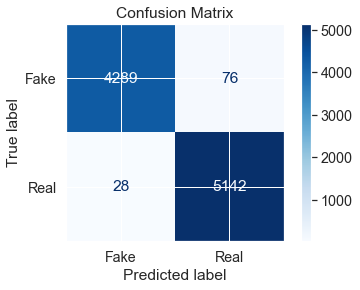

Accuracy_test = 98.909 %

Accuracy_train = 99.262 %

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4365
           1       0.99      0.99      0.99      5170

    accuracy                           0.99      9535
   macro avg       0.99      0.99      0.99      9535
weighted avg       0.99      0.99      0.99      9535



In [175]:
bestmodel_nb_text = run_bestpipe(allnews['text'], allnews['label'])

#### Log Probability:

Feature log probability is related to the probability of occurance of a certain feature in a class. 

In [181]:
#bestmodel_nb_text

In [182]:
#High probability of news being Real:
bestmodel_nb_text_log_prob_real = bestmodel_nb_text.sort_values(by=1, ascending=False)[:10]

In [183]:
# High probability of news being Fake:
bestmodel_nb_text_log_prob_fake = bestmodel_nb_text.sort_values(by=0, ascending=False)[:10]

In [184]:
bestmodel_nb_text_log_prob_top10 = display_side_by_side([bestmodel_nb_text_log_prob_real, bestmodel_nb_text_log_prob_fake],
                     ['HighProb-REAL', 'HighProb-FAKE'])

#### Stop_words:

Words are considered stop-words if they fulfill one of the following:<br>
+ they are so common that they occur in max_df or more documents.<br>
+ they are rare and can only be found in min_df or less documents.<br>
+ Are cutoff by feature selection (max_features).

In [185]:
print('number of stopwords in "bestmodel_nb_text" is = ', len(stopwords))

number of stopwords in "bestmodel_nb_text" is =  2775


In [188]:
import random

In [193]:
random.sample((stopwords), 11) # sample sample of stopwords

['ppe', 'bou', 'es ', 'n p', 'mi', 'ung', 'goo', 'ow,', ' vo', '016', 'sio']

In [209]:
len(vocab)

71507

In [205]:
random.sample((feature_names), 11)

['sp@', '“fb', 'rrk', ' v=', '#tc', 'arx', '1st', 'o/h', '6.d', '-k,', 'q0']

### Best Model - Passive Agressive:
### text

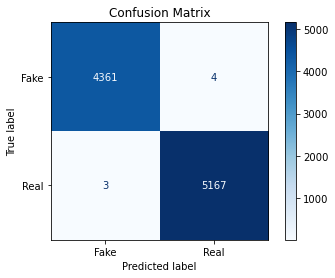

Accuracy_test = 99.927 %

Accuracy_train = 99.993 %

f1_test = 99.932 %

f1_train = 99.994 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4365
           1       1.00      1.00      1.00      5170

    accuracy                           1.00      9535
   macro avg       1.00      1.00      1.00      9535
weighted avg       1.00      1.00      1.00      9535



In [11]:
bestmodel_pa_text = run_bestpipe(allnews['text'],allnews['label'])

In [19]:
feature_coef_df = pd.DataFrame(bestmodel_pa_text, columns=feature_names).transpose()   

In [24]:
# most likely that it is Real news:
pa_text_most_likely_real = feature_coef_df.sort_values(by=0, ascending=False)[:15]

In [25]:
#Least likely that it is Real news
pa_text_least_likely_real = feature_coef_df.sort_values(by=0)[:15]

In [26]:
bestmodel_pa_text_coef_top15 = display_side_by_side([pa_text_most_likely_real, pa_text_least_likely_real],
                     ['HighProb-REAL', 'LowProb-REAL'])

In [13]:
from IPython.display import display_html
from IPython.display import HTML

In [1]:
#Words excluded because of min_df and max_df limitations
#pd.DataFrame(stopwords).transpose()[:20]

### Summary
The two *best* models were run using the *best* hyper-parameters from tuning.<br>

Naive Bayes model using 'text' - high probability real words were 'kor', 'syr' and high probability fake characters were 'fox' and '.h'. The f1-socre was 99%.<br>

PassiveAgressive classifier using 'text' - characters with a high probability of being real included 'reu', 'eut', '(re' etc. an indication that reuters in all its character combinations was a flag that the text was real. On the other side of the spectrum '!',and other characters showed in the high probability of being fake category. The f1-score was 99.9%.<br>

These high f1-scores were thought to be an indication of leakage: that some of the characters/words present in the training test were also present in the test set. This was investigated further by conducting a blind test with articles from another dataset (in section F).

### D. Multi-feature Classification:
Does combining title + title_length improve the model?

In [6]:
def feature_vect(series):
    vectorizer = TfidfVectorizer() # instantiate tfidfvectorizer
    vectorizer.fit(series)         # fit
    tfidf_vectors = vectorizer.transform(series) # transform
    return tfidf_vectors # return vector

In [6]:
#vectorizer = TfidfVectorizer(analyzer='char', max_df=0.4, min_df=1, ngram_range=(1,3), strip_accents='unicode')
vectorizer = TfidfVectorizer()

In [7]:
vectorizer.fit(allnews['title'])

TfidfVectorizer()

In [8]:
vectorizer.idf_

array([10.45035415,  6.35600959, 10.85581926, ..., 10.45035415,
       10.45035415, 10.85581926])

In [9]:
tfidf_vocab = vectorizer.get_feature_names()
len(tfidf_vocab)

20763

In [10]:
#tfidf_vocab

In [11]:
#using non-default best params from gridsearch
tfidf_vectors = vectorizer.transform(allnews['title'])
tfidf_vectors.shape

(38137, 20763)

In [10]:
#tfidf_vectors = vectorizer.transform(allnews['title'])
#tfidf_vectors.shape

(38137, 20763)

In [18]:
type(tfidf_vectors)

scipy.sparse.csr.csr_matrix

In [11]:
#convert to dense matrix and then dataframe
tfidf_vectors_df = pd.DataFrame(tfidf_vectors.todense(), columns=tfidf_vocab)
tfidf_vectors_df.head()

"   "a   "b   "c   "d   "e   "f   "g   "h   "i   "j   "m   "n   "o   "p  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    "r   "s   "t   "u   "v   "w    #   #1   #2   #3   #4   #5   #6   #7   #8  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    #9   #a   #b   #c   #d   #e   #f   #g   #h   #i   #j   #k   #l   #m   #n  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    #o   #p   #r   #s   #t   #u   #v   #w    $   $$   $.   $0   $1   $2   $3  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    $4   $5   $6   $7   $8   $9   $b    &   &     '   '1   '2   'a   'b   'c  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    'd   'e   'f   'g   'h   'i   'j   'k   'l   'm   'n   'o   'p   'q   'r  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    's   't   'u   'v   'w   'x   'y         (   (1   (2   (7   (?   (a   (b  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.070986  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   

    (c   (d   (e   (f   (g   (h        (i   (j   (l   (m   (n   (o   (p   (q  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.124935  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

    (r   (s   (t   (u   (v   (w   (y    *   **   *s    +   +    +$   +1   +2  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [12]:
tfidf_vectors_df['title_length'] = allnews['title_length']

In [13]:
Xm = tfidf_vectors_df
del tfidf_vectors_df

In [14]:
Xm['title_length'].head()

0    79
1    69
2    90
3    78
4    70
Name: title_length, dtype: int64

In [15]:
type(X_m)

pandas.core.frame.DataFrame

In [115]:
#scaler = StandardScaler()
#scaler.fit(X_m)
#Xn = scaler.transform(X_m)

In [16]:
X_m.shape

(38137, 17534)

In [13]:
y = allnews['label']

In [14]:
type(y)

pandas.core.series.Series

In [15]:
y.shape

(38137,)

In [84]:
allnews.head(2)

date                                              title  \
0  2017-12-31   Donald Trump Sends Out Embarrassing New Year’...   
1  2017-12-31   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  title_length  \
0  Donald Trump just couldn t wish all Americans ...    News            79   
1  House Intelligence Committee Chairman Devin Nu...    News            69   

   text_length  year  month weekday name  label  
0         2893  2017     12       Sunday      0  
1         1898  2017     12       Sunday      0

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, y, shuffle=True,
                                                    test_size=0.25, random_state=1234)

In [17]:
mnb = MultinomialNB(alpha=0.1)

In [18]:
mnb.fit(X_train,y_train)

MultinomialNB(alpha=0.1)

In [49]:
mnb_predict_train = mnb.predict(X_train)
mnb_predict_test = mnb.predict(X_test)
    
# Calculate score for train/test
f1_train = round(metrics.f1_score(y_train,mnb_predict_train), 4)
f1_test =  round(metrics.f1_score(y_test,mnb_predict_test), 4)

print('f1_train :', f1_train)
print('f1_test :', f1_test)

f1_train : 0.9707
f1_test : 0.9682


In [124]:
y_train.shape

(28602,)

In [125]:
X_test.shape


(9535, 1)

In [126]:
y_test.shape

(9535,)

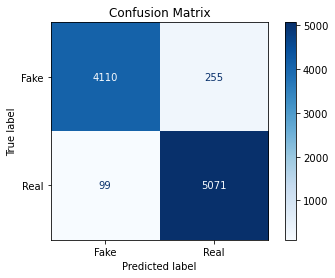

Accuracy_test = 96.287 %

Accuracy_train = 96.853 %

f1_train = 97.166 %

f1_test = 96.627 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      4365
           1       0.95      0.98      0.97      5170

    accuracy                           0.96      9535
   macro avg       0.96      0.96      0.96      9535
weighted avg       0.96      0.96      0.96      9535



In [23]:
# Using best_score from GridSearch for title:
mnb_title_plus_titlelength = run_bestpipe_with_titlelength(X_m, y)

### Summary
Running a Naive Bayes mode with 2 features: title, and title_length *did* result in an improvement in performance of the model(from f1_score of 95.9 to 96.6%), however using the single column 'text' had a much better result (99%).

## E. Model Comparisons:

Three classifiers will be compared in this section: Naive Bayes, Passive Agressive, and Logistic Regression.

The title column was converted to vectors using tfidfVectorizers, and fed into the function **run_exps**. This function runs the three models, carries out a 5-fold cross-validation and outputs five different scores (recall, precision, accuracy, f1 and roc_auc) in addition to the training and scoring times.

In [19]:
#X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, y, shuffle=True,
#                                                    test_size=0.25, random_state=1234)

In [102]:
X_vect = feature_vect(allnews['title'])

In [103]:
y = allnews['label']

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_vect, shuffle=True,
                                                    test_size=0.25, random_state=1234)

In [105]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, 
             y_test: pd.DataFrame) -> pd.DataFrame:
    
    global final
    '''
    Lightweight script to test many models and find winners:param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    courtesy of Cole Brendel
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegression(solver='liblinear', max_iter=5000)),
          ('PA', PassiveAggressiveClassifier()), 
          ('NB', MultinomialNB())

        ]

    results = []
    names = []
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    target_names = ['fake', 'real']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=33)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))

        results.append(cv_results)
        names.append(name)

        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)

        final = pd.concat(dfs, ignore_index=True)

    return final

In [106]:
run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

        fake       0.96      0.92      0.94      4295
        real       0.93      0.97      0.95      5240

    accuracy                           0.95      9535
   macro avg       0.95      0.94      0.95      9535
weighted avg       0.95      0.95      0.95      9535

PA
              precision    recall  f1-score   support

        fake       0.94      0.92      0.93      4295
        real       0.94      0.95      0.95      5240

    accuracy                           0.94      9535
   macro avg       0.94      0.94      0.94      9535
weighted avg       0.94      0.94      0.94      9535

NB
              precision    recall  f1-score   support

        fake       0.93      0.94      0.94      4295
        real       0.95      0.94      0.95      5240

    accuracy                           0.94      9535
   macro avg       0.94      0.94      0.94      9535
weighted avg       0.94      0.94      0.94      9535



fit_time  score_time  test_accuracy  test_precision  test_recall  \
0   0.136274    0.019060       0.948261        0.940473     0.967793   
1   0.115568    0.020124       0.943367        0.928660     0.969560   
2   0.443793    0.012255       0.941259        0.928908     0.964087   
3   0.072743    0.020346       0.942133        0.927704     0.970448   
4   0.085400    0.018373       0.941084        0.923734     0.972071   
5   0.060092    0.019526       0.948086        0.950691     0.955794   
6   0.060188    0.014514       0.940919        0.940988     0.950130   
7   0.087274    0.015162       0.933217        0.934240     0.941561   
8   0.071795    0.015627       0.943182        0.940112     0.957738   
9   0.058046    0.013026       0.937413        0.930647     0.956340   
10  0.011570    0.012027       0.947736        0.955238     0.950111   
11  0.006860    0.019014       0.938472        0.941006     0.945272   
12  0.011080    0.013670       0.934091        0.941776     0.934705   
13  0.013068    0.012312       0.937413        0.940879     0.945663   
14  0.010392    0.018102       0.937063        0.939674     0.945104   

     test_f1  test_roc_auc   model  
0   0.953937      0.987956  LogReg  
1   0.948669      0.987226  LogReg  
2   0.946171      0.986041  LogReg  
3   0.948595      0.986993  LogReg  
4   0.947286      0.987474  LogReg  
5   0.953236      0.986300      PA  
6   0.945537      0.985591      PA  
7   0.937886      0.982677      PA  
8   0.948843      0.984283      PA  
9   0.943319      0.984021      PA  
10  0.952667      0.987802      NB  
11  0.943134      0.986532      NB  
12  0.938227      0.983669      NB  
13  0.943265      0.984682      NB  
14  0.942382      0.985528      NB

In [129]:
final.sort_values(by='test_f1',ascending=False)

fit_time  score_time  test_accuracy  test_precision  test_recall  \
0   0.136274    0.019060       0.948261        0.940473     0.967793   
5   0.060092    0.019526       0.948086        0.950691     0.955794   
10  0.011570    0.012027       0.947736        0.955238     0.950111   
8   0.071795    0.015627       0.943182        0.940112     0.957738   
1   0.115568    0.020124       0.943367        0.928660     0.969560   
3   0.072743    0.020346       0.942133        0.927704     0.970448   
4   0.085400    0.018373       0.941084        0.923734     0.972071   
2   0.443793    0.012255       0.941259        0.928908     0.964087   
6   0.060188    0.014514       0.940919        0.940988     0.950130   
9   0.058046    0.013026       0.937413        0.930647     0.956340   
13  0.013068    0.012312       0.937413        0.940879     0.945663   
11  0.006860    0.019014       0.938472        0.941006     0.945272   
14  0.010392    0.018102       0.937063        0.939674     0.945104   
12  0.011080    0.013670       0.934091        0.941776     0.934705   
7   0.087274    0.015162       0.933217        0.934240     0.941561   

     test_f1  test_roc_auc   model  
0   0.953937      0.987956  LogReg  
5   0.953236      0.986300      PA  
10  0.952667      0.987802      NB  
8   0.948843      0.984283      PA  
1   0.948669      0.987226  LogReg  
3   0.948595      0.986993  LogReg  
4   0.947286      0.987474  LogReg  
2   0.946171      0.986041  LogReg  
6   0.945537      0.985591      PA  
9   0.943319      0.984021      PA  
13  0.943265      0.984682      NB  
11  0.943134      0.986532      NB  
14  0.942382      0.985528      NB  
12  0.938227      0.983669      NB  
7   0.937886      0.982677      PA

In [130]:
final.sort_values(by='score_time')

fit_time  score_time  test_accuracy  test_precision  test_recall  \
10  0.011570    0.012027       0.947736        0.955238     0.950111   
2   0.443793    0.012255       0.941259        0.928908     0.964087   
13  0.013068    0.012312       0.937413        0.940879     0.945663   
9   0.058046    0.013026       0.937413        0.930647     0.956340   
12  0.011080    0.013670       0.934091        0.941776     0.934705   
6   0.060188    0.014514       0.940919        0.940988     0.950130   
7   0.087274    0.015162       0.933217        0.934240     0.941561   
8   0.071795    0.015627       0.943182        0.940112     0.957738   
14  0.010392    0.018102       0.937063        0.939674     0.945104   
4   0.085400    0.018373       0.941084        0.923734     0.972071   
11  0.006860    0.019014       0.938472        0.941006     0.945272   
0   0.136274    0.019060       0.948261        0.940473     0.967793   
5   0.060092    0.019526       0.948086        0.950691     0.955794   
1   0.115568    0.020124       0.943367        0.928660     0.969560   
3   0.072743    0.020346       0.942133        0.927704     0.970448   

     test_f1  test_roc_auc   model  
10  0.952667      0.987802      NB  
2   0.946171      0.986041  LogReg  
13  0.943265      0.984682      NB  
9   0.943319      0.984021      PA  
12  0.938227      0.983669      NB  
6   0.945537      0.985591      PA  
7   0.937886      0.982677      PA  
8   0.948843      0.984283      PA  
14  0.942382      0.985528      NB  
4   0.947286      0.987474  LogReg  
11  0.943134      0.986532      NB  
0   0.953937      0.987956  LogReg  
5   0.953236      0.986300      PA  
1   0.948669      0.987226  LogReg  
3   0.948595      0.986993  LogReg

In [131]:
final.sort_values(by='fit_time')

fit_time  score_time  test_accuracy  test_precision  test_recall  \
11  0.006860    0.019014       0.938472        0.941006     0.945272   
14  0.010392    0.018102       0.937063        0.939674     0.945104   
12  0.011080    0.013670       0.934091        0.941776     0.934705   
10  0.011570    0.012027       0.947736        0.955238     0.950111   
13  0.013068    0.012312       0.937413        0.940879     0.945663   
9   0.058046    0.013026       0.937413        0.930647     0.956340   
5   0.060092    0.019526       0.948086        0.950691     0.955794   
6   0.060188    0.014514       0.940919        0.940988     0.950130   
8   0.071795    0.015627       0.943182        0.940112     0.957738   
3   0.072743    0.020346       0.942133        0.927704     0.970448   
4   0.085400    0.018373       0.941084        0.923734     0.972071   
7   0.087274    0.015162       0.933217        0.934240     0.941561   
1   0.115568    0.020124       0.943367        0.928660     0.969560   
0   0.136274    0.019060       0.948261        0.940473     0.967793   
2   0.443793    0.012255       0.941259        0.928908     0.964087   

     test_f1  test_roc_auc   model  
11  0.943134      0.986532      NB  
14  0.942382      0.985528      NB  
12  0.938227      0.983669      NB  
10  0.952667      0.987802      NB  
13  0.943265      0.984682      NB  
9   0.943319      0.984021      PA  
5   0.953236      0.986300      PA  
6   0.945537      0.985591      PA  
8   0.948843      0.984283      PA  
3   0.948595      0.986993  LogReg  
4   0.947286      0.987474  LogReg  
7   0.937886      0.982677      PA  
1   0.948669      0.987226  LogReg  
0   0.953937      0.987956  LogReg  
2   0.946171      0.986041  LogReg

In [107]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=100, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time']

# fit time metrics## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

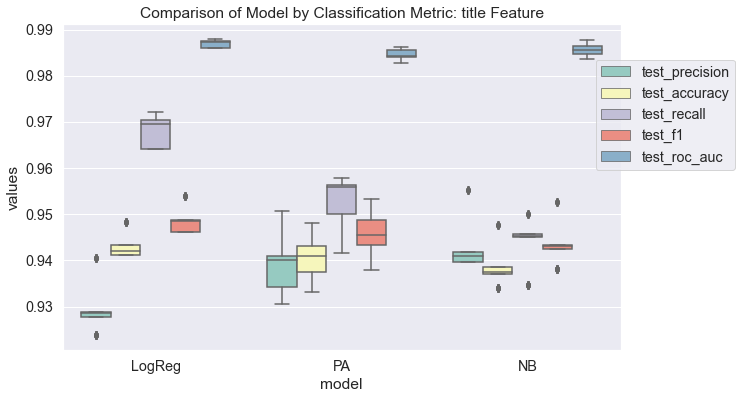

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(0.95, 0.9), loc=2, borderaxespad=0.2)
plt.title('Comparison of Model by Classification Metric: title Feature', fontsize=14);
plt.savefig('./benchmark_models_performance_title.png',dpi=300, bbox_inches='tight', pad_inches=1.0)

### Test Several Classifiers:
#### Text

In [132]:
X_vect = feature_vect(allnews['text'])

In [133]:
y_vect = allnews['label']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_vect, shuffle=True,
                                                    test_size=0.25, random_state=1234)

In [135]:
run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

        fake       0.99      0.98      0.98      4295
        real       0.98      0.99      0.99      5240

    accuracy                           0.98      9535
   macro avg       0.98      0.98      0.98      9535
weighted avg       0.98      0.98      0.98      9535

PA
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4295
        real       0.99      0.99      0.99      5240

    accuracy                           0.99      9535
   macro avg       0.99      0.99      0.99      9535
weighted avg       0.99      0.99      0.99      9535

NB
              precision    recall  f1-score   support

        fake       0.96      0.90      0.93      4295
        real       0.92      0.97      0.94      5240

    accuracy                           0.94      9535
   macro avg       0.94      0.93      0.93      9535
weighted avg       0.94      0.94      0.93      9535



fit_time  score_time  test_accuracy  test_precision  test_recall  \
0   1.756302    0.035906       0.984443        0.982143     0.989896   
1   1.867212    0.027925       0.983569        0.981660     0.988018   
2   2.711757    0.047864       0.980944        0.975838     0.988900   
3   1.834098    0.049234       0.984790        0.979624     0.993009   
4   1.842074    0.033909       0.981818        0.977785     0.989085   
5   0.448551    0.031915       0.991610        0.990255     0.994632   
6   0.409977    0.030889       0.991785        0.991276     0.993523   
7   0.395985    0.031872       0.988636        0.986057     0.992817   
8   0.398936    0.030916       0.994056        0.993031     0.996187   
9   0.422870    0.025932       0.991958        0.989162     0.996148   
10  0.154584    0.043884       0.936550        0.921781     0.967477   
11  0.108679    0.041983       0.930257        0.905336     0.972474   
12  0.109706    0.037899       0.931119        0.909481     0.967679   
13  0.105860    0.037898       0.936713        0.919807     0.969495   
14  0.101197    0.036804       0.940035        0.922046     0.972071   

     test_f1  test_roc_auc   model  
0   0.986004      0.998215  LogReg  
1   0.984829      0.997783  LogReg  
2   0.982325      0.997647  LogReg  
3   0.986271      0.998443  LogReg  
4   0.983402      0.997354  LogReg  
5   0.992439      0.999464      PA  
6   0.992399      0.999366      PA  
7   0.989426      0.999051      PA  
8   0.994607      0.999479      PA  
9   0.992642      0.999096      PA  
10  0.944076      0.984115      NB  
11  0.937705      0.983096      NB  
12  0.937678      0.981786      NB  
13  0.943998      0.984676      NB  
14  0.946398      0.984526      NB

In [137]:
final.sort_values(by='fit_time')

fit_time  score_time  test_accuracy  test_precision  test_recall  \
14  0.101197    0.036804       0.940035        0.922046     0.972071   
13  0.105860    0.037898       0.936713        0.919807     0.969495   
11  0.108679    0.041983       0.930257        0.905336     0.972474   
12  0.109706    0.037899       0.931119        0.909481     0.967679   
10  0.154584    0.043884       0.936550        0.921781     0.967477   
7   0.395985    0.031872       0.988636        0.986057     0.992817   
8   0.398936    0.030916       0.994056        0.993031     0.996187   
6   0.409977    0.030889       0.991785        0.991276     0.993523   
9   0.422870    0.025932       0.991958        0.989162     0.996148   
5   0.448551    0.031915       0.991610        0.990255     0.994632   
0   1.756302    0.035906       0.984443        0.982143     0.989896   
3   1.834098    0.049234       0.984790        0.979624     0.993009   
4   1.842074    0.033909       0.981818        0.977785     0.989085   
1   1.867212    0.027925       0.983569        0.981660     0.988018   
2   2.711757    0.047864       0.980944        0.975838     0.988900   

     test_f1  test_roc_auc   model  
14  0.946398      0.984526      NB  
13  0.943998      0.984676      NB  
11  0.937705      0.983096      NB  
12  0.937678      0.981786      NB  
10  0.944076      0.984115      NB  
7   0.989426      0.999051      PA  
8   0.994607      0.999479      PA  
6   0.992399      0.999366      PA  
9   0.992642      0.999096      PA  
5   0.992439      0.999464      PA  
0   0.986004      0.998215  LogReg  
3   0.986271      0.998443  LogReg  
4   0.983402      0.997354  LogReg  
1   0.984829      0.997783  LogReg  
2   0.982325      0.997647  LogReg

In [138]:
final.sort_values(by='score_time')

fit_time  score_time  test_accuracy  test_precision  test_recall  \
9   0.422870    0.025932       0.991958        0.989162     0.996148   
1   1.867212    0.027925       0.983569        0.981660     0.988018   
6   0.409977    0.030889       0.991785        0.991276     0.993523   
8   0.398936    0.030916       0.994056        0.993031     0.996187   
7   0.395985    0.031872       0.988636        0.986057     0.992817   
5   0.448551    0.031915       0.991610        0.990255     0.994632   
4   1.842074    0.033909       0.981818        0.977785     0.989085   
0   1.756302    0.035906       0.984443        0.982143     0.989896   
14  0.101197    0.036804       0.940035        0.922046     0.972071   
13  0.105860    0.037898       0.936713        0.919807     0.969495   
12  0.109706    0.037899       0.931119        0.909481     0.967679   
11  0.108679    0.041983       0.930257        0.905336     0.972474   
10  0.154584    0.043884       0.936550        0.921781     0.967477   
2   2.711757    0.047864       0.980944        0.975838     0.988900   
3   1.834098    0.049234       0.984790        0.979624     0.993009   

     test_f1  test_roc_auc   model  
9   0.992642      0.999096      PA  
1   0.984829      0.997783  LogReg  
6   0.992399      0.999366      PA  
8   0.994607      0.999479      PA  
7   0.989426      0.999051      PA  
5   0.992439      0.999464      PA  
4   0.983402      0.997354  LogReg  
0   0.986004      0.998215  LogReg  
14  0.946398      0.984526      NB  
13  0.943998      0.984676      NB  
12  0.937678      0.981786      NB  
11  0.937705      0.983096      NB  
10  0.944076      0.984115      NB  
2   0.982325      0.997647  LogReg  
3   0.986271      0.998443  LogReg

In [139]:
final.sort_values(by='test_f1', ascending=False)

fit_time  score_time  test_accuracy  test_precision  test_recall  \
8   0.398936    0.030916       0.994056        0.993031     0.996187   
9   0.422870    0.025932       0.991958        0.989162     0.996148   
5   0.448551    0.031915       0.991610        0.990255     0.994632   
6   0.409977    0.030889       0.991785        0.991276     0.993523   
7   0.395985    0.031872       0.988636        0.986057     0.992817   
3   1.834098    0.049234       0.984790        0.979624     0.993009   
0   1.756302    0.035906       0.984443        0.982143     0.989896   
1   1.867212    0.027925       0.983569        0.981660     0.988018   
4   1.842074    0.033909       0.981818        0.977785     0.989085   
2   2.711757    0.047864       0.980944        0.975838     0.988900   
14  0.101197    0.036804       0.940035        0.922046     0.972071   
10  0.154584    0.043884       0.936550        0.921781     0.967477   
13  0.105860    0.037898       0.936713        0.919807     0.969495   
11  0.108679    0.041983       0.930257        0.905336     0.972474   
12  0.109706    0.037899       0.931119        0.909481     0.967679   

     test_f1  test_roc_auc   model  
8   0.994607      0.999479      PA  
9   0.992642      0.999096      PA  
5   0.992439      0.999464      PA  
6   0.992399      0.999366      PA  
7   0.989426      0.999051      PA  
3   0.986271      0.998443  LogReg  
0   0.986004      0.998215  LogReg  
1   0.984829      0.997783  LogReg  
4   0.983402      0.997354  LogReg  
2   0.982325      0.997647  LogReg  
14  0.946398      0.984526      NB  
10  0.944076      0.984115      NB  
13  0.943998      0.984676      NB  
11  0.937705      0.983096      NB  
12  0.937678      0.981786      NB

In [140]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=100, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time']

# fit time metrics## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

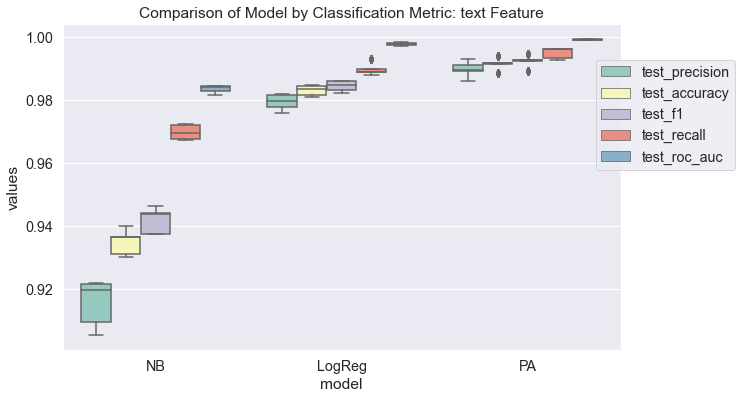

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.3)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(0.95, 0.9), loc=2, borderaxespad=0.2)
plt.title('Comparison of Model by Classification Metric: text Feature', fontsize=14);
plt.savefig('./benchmark_models_performance_text.png',dpi=300,bbox_inches='tight', pad_inches=1.0)

### Summary: 
All 3 models have comperable performance in terms of accuracy and f1, with Logistric Regression having a slight advantage - a difference of <0.5% from both other models.<br>

Naive Bayes is the fastest to train. it is about 3 to 4 times faster than Passive Agressive classifier, and up to 10times or more, faster than Logistic Regression.<br>



I also attempted to include RandomForest and SVC. They took considerably longer, especially SVC(), and resulted in memory issues.

### F. Stress tests :
10 articles randomly chosen from another kaggle set and fed into the model. <br>
How does the model perform on unseen data?

In [32]:
data = pd.read_csv('stress_test.csv', index_col='Unnamed: 0') # import blind dataset

In [34]:
subdata = data.dropna()  # drop rows with missing data

In [1]:
#subdata['title_length'] = subdata['title'].apply(len)
#subdata['text_length'] = subdata['text'].apply(len)

In [42]:
stress_test = subdata.head(10) # 10 rows selected for testing
stress_test

id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

                                                text  label  title_length  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1            81   
1  Ever get the feeling your life circles the rou...      0            55   
2  Why the Truth Might Get You Fired October 29, ...      1            33   
3  Videos 15 Civilians Killed In Single US Airstr...      1            63   
4  Print \nAn Iranian woman has been sentenced to...      1            93   
5  In these trying times, Jackie Mason is the Voi...      0           124   
6  Ever wonder how Britain’s most iconic pop pian...      1           110   
7  PARIS  —   France chose an idealistic, traditi...      0            87   
8  Donald J. Trump is scheduled to make a highly ...      0           104   
9  A week before Michael T. Flynn resigned as nat...      0            93   

   text_length  
0         4930  
1         4160  
2         7692  
3         3237  
4          938  
5         1192  
6         2729  
7         4923  
8         8177  
9        10261

Predictions Using Naive Bayes:<br>
A) 'text'

In [47]:
Xs = stress_test['text']
ys = stress_test['label']

vectorizer = TfidfVectorizer()
vectorizer.fit(Xs)
tfidf_vectors_Xs = vectorizer.transform(Xs)

In [48]:
# Prepare Model:

X = allnews['text']
y = allnews['label']

#Pipeline:
pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_df=0.1, min_df= 1, stop_words=None, analyzer='char',
                                     strip_accents=None, ngram_range=(1,3))),
            ('classifier', MultinomialNB(alpha=0.1))
        ])

# fit model
pipe.fit(X,y)

# Predict the stress data using Model:
#
ys_pred = pipe.predict(Xs)

# Evaluate predictions   
print(confusion_matrix(ys, ys_pred))
print(classification_report(ys,ys_pred))

[[1 4]
 [0 5]]
              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.56      1.00      0.71         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10



In [49]:
ys_pred = pipe.predict(Xs)

In [50]:
stress_test['prediction'] = ys_pred

<ipython-input-50-1360c53cba45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_test['prediction'] = ys_pred


In [51]:
stress_test

id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

                                                text  label  title_length  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1            81   
1  Ever get the feeling your life circles the rou...      0            55   
2  Why the Truth Might Get You Fired October 29, ...      1            33   
3  Videos 15 Civilians Killed In Single US Airstr...      1            63   
4  Print \nAn Iranian woman has been sentenced to...      1            93   
5  In these trying times, Jackie Mason is the Voi...      0           124   
6  Ever wonder how Britain’s most iconic pop pian...      1           110   
7  PARIS  —   France chose an idealistic, traditi...      0            87   
8  Donald J. Trump is scheduled to make a highly ...      0           104   
9  A week before Michael T. Flynn resigned as nat...      0            93   

   text_length  prediction  
0         4930           1  
1         4160           1  
2         7692           1  
3         3237           1  
4          938           1  
5         1192           1  
6         2729           1  
7         4923           1  
8         8177           0  
9        10261           1

 B) Naive Bayes - title:

In [67]:
Xs = stress_test['title']
ys = stress_test['label']

vectorizer = TfidfVectorizer()
vectorizer.fit(Xs)
tfidf_vectors_Xs = vectorizer.transform(Xs)

In [68]:
# Prepare Model:

X = allnews['title']
y = allnews['label']

#Pipeline:
pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_df=0.4, min_df= 1, stop_words=None, analyzer='char',
                                     strip_accents='unicode', ngram_range=(1,3))),
            ('classifier', MultinomialNB(alpha=0.1))
        ])

# fit model
pipe.fit(X,y)

# Predict the stress data using Model:
#
ys_pred = pipe.predict(Xs)

# Evaluate predictions   
print(confusion_matrix(ys, ys_pred))
print(classification_report(ys,ys_pred))

[[2 3]
 [3 2]]
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10



In [109]:
# print idf values 
nb_title_subdata_feature_idf = pd.DataFrame(pipe.steps[0][1].idf_, 
                                             index=pipe.steps[0][1].get_feature_names(),columns=["idf_weights"]) 
 
# idf sort ascending 
_ascend = nb_title_subdata_feature_idf.sort_values(by=['idf_weights']).head(15)
_desc = nb_title_subdata_feature_idf.sort_values(by=['idf_weights'], ascending=False).head(15)

# log_probabilities
nb_title_subdata_feature_log_prob = pd.DataFrame(pipe.steps[1][1].feature_log_prob_, 
                                             columns=pipe.steps[0][1].get_feature_names()).transpose() 
log_prob_fake_desc = nb_title_subdata_feature_log_prob.sort_values(by=0, ascending=False).head(50)
log_prob_real_desc = nb_title_subdata_feature_log_prob.sort_values(by=1,ascending=False).head(50)

# coefficients (Real)
nb_title_subdata_feature_coef = pd.DataFrame(pipe.steps[1][1].coef_, 
                                             columns=pipe.steps[0][1].get_feature_names()).transpose() 
nb_title_coef_real_desc = nb_title_subdata_feature_coef.sort_values(by=0, ascending=False).head(50).transpose()

In [198]:
display_side_by_side([_ascend, _desc], ['Most Common Characters', 'Least Common Characters'])

In the table below, 0 represents Fake and 1 represents Real news. The log probabilities are shown.<br>
It is interesting to note that characters found in the name 'Trump' appear in the top 50  bi-grams and tri-grams. The probabilities in all cases are higher in the Fake category than the Real cateogry. For example 'mp' has a log probability of -6.237 of it being Fake and a log probability of -6.428 of it being Real(i.e. a slightly higher probability of it being Fake than Real).<br>

This shows up in the label predictions where both titles with 'Trump' are (correctly) predicted as Fake.<br>
For the title with the word 'Hillary', where many characters in the name show up in the top 50 n-grams with the high probablity of being Fake(h:-5.952 / ll:-6.185 / hi:-6.214 / il:-63772 / la:-6.39 / l:-6.4295), we find that the title is erroneously predicted to be *real*.<br>

This is probably because, simultaneously, *more* of the characters in the rest of the title ('Hillary Clinton, Big Woman on Campus') are in the top 50 high probability of being Real(on:-6.26 / m:-6.26 / ma:-6.36 / ca: -6.379 / us:-6.39 / mp:-6.428 /a:-6.426 / w:-6.417 / an:-6.422).<br>

It is of note that the stress-test data is **not** from the dataset used to train or test the model.

In [206]:
stress_test.iloc[1]['title']

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [200]:
display_side_by_side([log_prob_fake_desc, log_prob_real_desc], 
                     ['High Probability Fake', 'High Probability Real'])

In [110]:
nb_title_coef_real_desc

'         .        se        it        ea       li        to  \
0 -5.820708 -5.828652 -6.048879 -6.114462 -6.145425 -6.18826 -6.190099   

        on         ta      to         ra        is        ia       nt  \
0 -6.196336 -6.199694 -6.20013 -6.208066 -6.224624 -6.236817 -6.24008   

         si        ri         m        le        co        io         b  \
0 -6.245204 -6.245707 -6.260693 -6.265129 -6.267398 -6.270592 -6.271225   

         l        ion        ic         d        ou        in        ma  \
0 -6.297062 -6.302664 -6.303592 -6.324387 -6.336489 -6.343746 -6.361094   

        sa        ur        ng        ns        ne        ca        u.  \
0 -6.36251 -6.363864 -6.367456 -6.372229 -6.375966 -6.379086 -6.389943   

         us        me        ce       in         ro       es        er   \
0 -6.390539 -6.391105 -6.391782 -6.396711 -6.405548 -6.406786 -6.407574   

          w       ay       an         ve        's       a         mp  \
0 -6.409911 -6.41782 -6.422116 -6.422904 -6.426302 -6.42671 -6.428145   

         re  
0 -6.428365

In [115]:
stress_test.iloc[1]['title']

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart'

In [116]:
ys_pred = pipe.predict(Xs)

In [117]:
stress_test['prediction'] = ys_pred

<ipython-input-117-1360c53cba45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_test['prediction'] = ys_pred


PassiveAggressive Model:

C) 'text'

In [56]:
# Prepare Model:

X = allnews['text']
y = allnews['label']

#Pipeline:
pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_df=0.8, min_df= 3, stop_words=None, analyzer='char',
                                     strip_accents=None, ngram_range=(1,3))),
            ('classifier', PassiveAggressiveClassifier(C=0.001, loss='squared_hinge'))
        ])

# fit model
pipe.fit(X,y)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(analyzer='char', max_df=0.8, min_df=3,
                                 ngram_range=(1, 3))),
                ('classifier',
                 PassiveAggressiveClassifier(C=0.001, loss='squared_hinge'))])

In [57]:
# Predict the stress data using Model:
#
ys_pred = pipe.predict(Xs)

# Evaluate predictions   
print(confusion_matrix(ys, ys_pred))
print(classification_report(ys,ys_pred))

[[1 4]
 [1 4]]
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.50      0.80      0.62         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10



In [58]:
# print idf values 
pa_text_subdata_feature_idf = pd.DataFrame(pipe.steps[0][1].idf_, 
                                             index=pipe.steps[0][1].get_feature_names(),columns=["idf_weights"]) 
 
# idf sort ascending 
_ascend = pa_text_subdata_feature_idf.sort_values(by=['idf_weights']).head(15)
_desc = pa_text_subdata_feature_idf.sort_values(by=['idf_weights'], ascending=False).head(15)

# log_probabilities
#pa_text_subdata_feature_log_prob = pd.DataFrame(pipe.steps[1][1].feature_log_prob_, 
                                             #columns=pipe.steps[0][1].get_feature_names()).transpose() 
#log_prob_fake_desc = pa_text_subdata_feature_log_prob.sort_values(by=0, ascending=False).head(50)
#log_prob_real_desc = pa_text_subdata_feature_log_prob.sort_values(by=1,ascending=False).head(50)

# coefficients (Real)
pa_text_subdata_feature_coef = pd.DataFrame(pipe.steps[1][1].coef_, 
                                             columns=pipe.steps[0][1].get_feature_names()).transpose() 
pa_text_coef_real_desc = pa_text_subdata_feature_coef.sort_values(by=0, ascending=False).head(50).transpose()

In [59]:
len(pa_text_subdata_feature_coef)

43848

In [60]:
# Coefficients, ascending
pa_text_subdata_feature_coef.sort_values(by=0).transpose()

.t         :       .th        s        thi        :         .a  \
0 -2.417136 -2.213833 -2.143214 -1.502937 -1.497518 -1.365036 -1.324473   

        t          !        .i         ?       via         /        .c  \
0 -1.23305 -1.172714 -1.056301 -1.001341 -0.914143 -0.912651 -0.892357   

         !        ia:        a:        e:       a:         us       ma   \
0 -0.881153 -0.851343 -0.832121 -0.802228 -0.801681 -0.779809 -0.757306   

         .f       bam       eri       you       s.t        ?         am  \
0 -0.752832 -0.743662 -0.738683 -0.735255 -0.721535 -0.719991 -0.717259   

        oba       .in       ame       eve        .h       ima        .b  \
0 -0.711563 -0.707071 -0.699113 -0.694639 -0.690529 -0.681781 -0.679307   

        lly       , 2       e:         ou        ob       mp         .w  \
0 -0.678682 -0.674605 -0.673802 -0.670861 -0.668903 -0.665504 -0.663476   

        t s         @       us        ou         yo       re:       .co  \
0 -0.658945 -0.652402 -0.652105 -0.645902 -0.643878 -0.640438 -0.634162   

        ric        tt        ev        s:        ob        .r        (@  \
0 -0.632537 -0.615007 -0.604016 -0.600482 -0.595845 -0.593824 -0.593379   

         (@       .re       sn         vi      hil       mag       wir  \
0 -0.593212 -0.583611 -0.582092 -0.580321 -0.57362 -0.569831 -0.565431   

        rea      ica        cl       yo        .m       mer       jus  \
0 -0.565392 -0.56307 -0.560137 -0.54542 -0.543795 -0.535439 -0.534474   

         sn        hi       e.t       cli        oo        %        .v  \
0 -0.518966 -0.517091 -0.513377 -0.504533 -0.503651 -0.50045 -0.498989   

         .o       ie        p s       son       ow        wha       d.t  \
0 -0.498782 -0.496686 -0.492761 -0.490065 -0.485334 -0.483392 -0.480702   

         mr       hes        .p       lla       dn        .fe       .vi  \
0 -0.478065 -0.477421 -0.477088 -0.472881 -0.472624 -0.471689 -0.466068   

        lai       wat       int       eat       act       ur        ke   \
0 -0.465883 -0.458551 -0.458382 -0.458304 -0.457309 -0.453596 -0.453558   

        ama        nn      rum       gop      now       ary       ump  \
0 -0.451958 -0.448738 -0.44866 -0.448125 -0.44714 -0.446797 -0.446335   

        ey        deo       nto       o t        ey       tty       mr  \
0 -0.446315 -0.446016 -0.443602 -0.439881 -0.438931 -0.438765 -0.43481   

        ror        .d       fox       tru       .a        ell       s.a  \
0 -0.434592 -0.431769 -0.431053 -0.430673 -0.430099 -0.426594 -0.426151   

        ge        e v       .he       hen       hey       ett        li  \
0 -0.422568 -0.419093 -0.417007 -0.413333 -0.406331 -0.405865 -0.404844   

        get         $       rro        ws       ord        im       lar  \
0 -0.404269 -0.403902 -0.399563 -0.398049 -0.397866 -0.397153 -0.390818   

         ck        oe       bla       e d        21        %         ox  \
0 -0.390475 -0.390177 -0.388013 -0.386699 -0.386364 -0.385796 -0.384425   

        n.t       mr.       om/        r.       atc       .tw       one  \
0 -0.383083 -0.381168 -0.379267 -0.378566 -0.377199 -0.373939 -0.373863   

         t:        m/       tch       how       r.c       ery       ton  \
0 -0.372529 -0.371876 -0.371414 -0.371391 -0.371076 -0.369124 -0.368332   

         dm       t.t        hy       ck        fea       .ac       y.t  \
0 -0.365497 -0.365237 -0.364288 -0.363001 -0.360163 -0.357706 -0.357549   

        c.t       .bu       .wh       way        fb       rtm       age  \
0 -0.354914 -0.354869 -0.353341 -0.350523 -0.350394 -0.349559 -0.348773   

        tod        tl       ox        pay        ju       adm       mor  \
0 -0.348287 -0.347979 -0.347471 -0.346786 -0.345478 -0.345061 -0.343533   

        oes       scr       nfo         j        1s        e.      out  \
0 -0.339685 -0.338839 -0.338247 -0.333073 -0.332752 -0.332613 -0.33261   

        .on        um      s.i       can       stu       ven         #  \
0 -0.332351 -0.331741 -0.33

In [61]:
# Coefficients descending
pa_text_coef_real_desc

sai        ’        -          -        -         eu       reu  \
0  2.56345  2.48015  2.262013  2.250422  2.248108  2.094258  2.020836   

        eut        ’s       ’s        ute         “         “         ”  \
0  2.011402  1.919759  1.912237  1.799667  1.753592  1.750619  1.743145   

         ”        ) -       (re       rs)       s)         (r        s)  \
0  1.714176  1.662393  1.654446  1.622205  1.519004  1.515288  1.449254   

         (r       d.         )         ..       . “         (        ,”  \
0  1.443557  1.126871  1.104032  0.947717  0.929571  0.857316  0.849929   

          )       ,”          (       id.        u.       sda       - t  \
0  0.848962  0.848783  0.828851  0.767519  0.752365  0.744389  0.734666   

        - a        sd       ita     u.       y.        u.s       , s  \
0  0.725288  0.703729  0.703488  0.681  0.672494  0.626239  0.625655   

        .s.       esd       had        n’       n (       nis       . p  \
0  0.617128  0.606875  0.603934  0.592141  0.589935  0.582673  0.577014   

        rli  
0  0.565142

In [62]:
stress_test.iloc[0]['title']

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [65]:
stress_test['prediction'] = ys_pred

<ipython-input-65-1360c53cba45>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress_test['prediction'] = ys_pred


In [66]:
stress_test

id                                              title  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2   2                  Why the Truth Might Get You Fired   
3   3  15 Civilians Killed In Single US Airstrike Hav...   
4   4  Iranian woman jailed for fictional unpublished...   
5   5  Jackie Mason: Hollywood Would Love Trump if He...   
6   6  Life: Life Of Luxury: Elton John’s 6 Favorite ...   
7   7  Benoît Hamon Wins French Socialist Party’s Pre...   
8   8  Excerpts From a Draft Script for Donald Trump’...   
9   9  A Back-Channel Plan for Ukraine and Russia, Co...   

                                                text  label  title_length  \
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1            81   
1  Ever get the feeling your life circles the rou...      0            55   
2  Why the Truth Might Get You Fired October 29, ...      1            33   
3  Videos 15 Civilians Killed In Single US Airstr...      1            63   
4  Print \nAn Iranian woman has been sentenced to...      1            93   
5  In these trying times, Jackie Mason is the Voi...      0           124   
6  Ever wonder how Britain’s most iconic pop pian...      1           110   
7  PARIS  —   France chose an idealistic, traditi...      0            87   
8  Donald J. Trump is scheduled to make a highly ...      0           104   
9  A week before Michael T. Flynn resigned as nat...      0            93   

   text_length  prediction  
0         4930           0  
1         4160           1  
2         7692           1  
3         3237           1  
4          938           1  
5         1192           1  
6         2729           1  
7         4923           1  
8         8177           0  
9        10261           1

### Clean 'text'

In [122]:
# Retain ONLY alphabetical letters in 'text'
# Re-name cleaned 'text' as corpus

allnews['text'].reset_index()  # re-index to re-order after dropna()
corpus=[]
for i in range(0,len(allnews)):
    X_clean = re.sub('[^a-zA-Z]', ' ', allnews.iloc[i]['text'])
    corpus.append(X_clean)

In [107]:
corpus[10]

' Papa John s Founder Retires  Figures Out Racism Is Bad For Business'

In [106]:
# Show cleaned 'text'
allnews.iloc[10]['title']

' Papa John’s Founder Retires, Figures Out Racism Is Bad For Business'

In [85]:
import re

Clean Stress_test 'text' data

In [124]:
# Drop all characters, symbols and numbers. Retain only alphabetical letters
# Rename as corpus_test

corpus_test = []
for i in range(0,len(stress_test)):
    X_test_clean = re.sub('[^a-zA-Z]', ' ', stress_test.iloc[i]['text'])
    corpus_test.append(X_test_clean)

Vectorize and Transform

In [126]:
Xs = corpus_test
ys = stress_test['label']

vectorizer = TfidfVectorizer()
vectorizer.fit(Xs)
tfidf_vectors_Xs = vectorizer.transform(Xs)

Run mode/Predict and Evaluate

In [127]:
X = corpus
y = allnews['label']

#Pipeline:
pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_df=0.1,min_df= 1, stop_words=None, analyzer='char',
                                     strip_accents=None, ngram_range=(1,3))),
            ('classifier', MultinomialNB(alpha=0.1))
        ])

# fit model
pipe.fit(X,y)

# Predict the stress data using Model:
#
ys_pred = pipe.predict(Xs)

# Evaluate predictions   
print(confusion_matrix(ys, ys_pred))
print(classification_report(ys,ys_pred))

[[4 1]
 [2 3]]
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.75      0.60      0.67         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10



### Summary:
Ten news articles never seen before by the model were used in a stress test. As expected, models that use the text (body of the article) performed better than those that used only the title.<br>
The Naive Bayes 'text' model, had the best performance, in predicting the label of the unseen data:<br>

**Fake** - 1 out of 5 were correctly predicted.<br>
of those predicted as fake, all were correct.<br>
**Real** - were all correctly predicted.<br>
of those predicted as real, 5 out of 9 were correct.<br>
The accuracy score was 60%.<br>
f1 scores: *Real*= 71% , *Fake*= 33%

Up until this point in the project, all models perform better in predicting which news was *real*. They all had a more challenging time in predicting which news was *fake*.

In order to improve the performance further,  all characters and numbers were removed from the 'text' of the news articles and only the alphabetical characters were retained. The new Naive Bayes model's accuracy was considerably improved to 70%! And even though less *real* news was correctly predicted, the number of *fake* news that were wrongly classified as *real*, was decreased significantly. Below is a summary:<br>

**Fake** - 4 out of 5 were correctly predicted.<br>
of those predicted as fake, 4 out of 6 were correct.<br>
**Real** - 3 out of 5 were correctly predicted.<br>
of those predicted as real, 3 out of 4 were correct.<br>
The accuracy score was 70%.<br>
f1 scores: *Real*=67%  , *Fake*=73%.

The PassiveAgressive model also benefited from dropping of all characters and numbers from the body of the article(text), but its performance was surpassed by the Naive Bayes model.

### G. Conclusion 

Supervised learning worked well in predicting whether a news article is Real or Fake from within the **same kaggle dataset** (f1=99%). However, when introducing articles from other datasets, the performance was considerably lower. Removal of characters, numbers and symbols from the body of the news article considerably improved the performance of the models. Maximum improvement was seen in the **Naive Bayes model where accuracy increased by 10% (from 60% to 70%), Fake news f1-score increased by 40%(from 33-73%), and f1-score for Real news dropped by 4% (71-67%)**.<br>

Numerical, categorical and datetime features were skipped in order to focus on Natural Language features.<br>

Title_length of the Fake and Real data showed a separation between their means. A multi-feature model using 'title' and 'title_length' was tested. This model led to a slight improvement in the performance (from f1:95.9 to 96.6%) when compared to the 'title' only model.<br>

### H. Future Recommendations

Combine features from title, and text and perhaps title_length to produce a model containing these and any other numerical features extracted from the data(datetime).<br>

It is recommended that more complex methods such as neural networks are tested in the future in order to further generalize the model.<br>

### References:
- “The Spread of True and False News Online" by S.Vosoughi etal. Massachusetts Institute of Technology (MIT).Science, 09March 2018, vol359, issue 6380, pp 1146-1151. https://science.sciencemag.org/content/359/6380/1146

- "Quickly Compare Multiple Models: How to train and evaluate multiple models efficiently" by Cole Brenel. Medium, 14 May. 
https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

*Dataset formed from posts and ratings in https://www.politifact.com/
